<a href="https://colab.research.google.com/github/daniel-muthukrishna/transomaly/blob/master/compare_methods_bazin_mock_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AEyymZoIN264MJlVYefWAUCv5fDP8zz_9ur3jS-K8eVEmB1K8XoTBc
Mounted at /content/gdrive


In [2]:
! pip install astrorapid
! pip install emcee
! pip install corner
# ! pip install celerite
# ! pip install keras-tcn
# ! pip install tensorflow-gpu

     |████████████████████████████████| 8.3MB 5.1MB/s 
     |████████████████████████████████| 153kB 58.4MB/s 
  Created wheel for extinction: filename=extinction-0.4.0-cp36-cp36m-linux_x86_64.whl size=328511 sha256=ee605d421f3216e7808bd47657bdbafa4a18be7e3fcb3527129ae3526c617226
  Stored in directory: /root/.cache/pip/wheels/f3/b4/65/aac6a9be9d670e4da20675b82671fb1475044408ebcdecfc9b
Successfully built extinction
     |████████████████████████████████| 51kB 3.1MB/s 


In [3]:
% cd /content/gdrive/My Drive/Projects/transomaly

/content/gdrive/My Drive/Projects/transomaly


In [ ]:
#@title NN Imports
import os
import numpy as np
import h5py
import pickle
import copy

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, Masking, Input, Dropout

import tensorflow_probability as tfp
tfd = tfp.distributions

from tcn import TCN, tcn_full_summary
# from bayesian_tcn import TCN, tcn_full_summary

import astrorapid

from transomaly.prepare_training_set import PrepareTrainingSetArrays
from transomaly.loss_functions import mean_squared_error, chisquare_loss, mean_squared_error_over_error, negloglike, negloglike_with_error
from transomaly.plot_metrics import plot_history  # , plot_metrics
import transomaly

In [ ]:
#@title Define plot_metrics function

COLPB = {'g': 'tab:green', 'r': 'tab:red', 'gpred': 'turquoise', 'rpred': 'tab:pink'}
MARKPB = {'g': 'o', 'r': 's', 'z': 'd'}
ALPHAPB = {'g': 0.3, 'r': 1., 'z': 1}
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import json

from transomaly.fit_gaussian_processes import save_gps
from astrorapid.get_training_data import get_data
from transomaly import helpers

def plot_metrics(model, model_name, X_test, y_test, timesX_test, yerr_test, labels_test, objids_test, passbands, fig_dir, nsamples, data_dir,  save_dir, nprocesses, plot_gp=False, extrapolate_gp=True, reframe=False, plot_name='', npred=49, probabilistic=False, known_redshift=False, get_data_func=None, normalise=False, bayesian=False):
    print(model_name)
    nobjects, ntimesteps, nfeatures = X_test.shape
    npassbands = len(passbands)

    sampled_ypred = []
    sampled_ystd = []
    draws = []
    if probabilistic:
        X_test = np.asarray(X_test, np.float32)
        y_test = np.asarray(y_test, np.float32)
        # yhat = model(X_test)
        # y_pred = np.asarray(yhat.mean())
        # y_pred_std = np.asarray(yhat.stddev())
        if bayesian:
            ns = 100
            for i in range(ns):
                sampled_yhat = model(X_test)
                sampled_ypred.append(np.asarray(sampled_yhat.mean()))
                sampled_ystd.append(np.asarray(sampled_yhat.stddev()))
                draws.append(np.random.normal(sampled_yhat.mean(), sampled_yhat.stddev()))
            # plot_mean_ypred = np.mean(np.array(sampled_ypred), axis=0)
            # plot_sigma_ypred = np.std(np.array(sampled_ypred), axis=0)
            plot_mean_ypred = np.mean(np.array(draws), axis=0)
            plot_sigma_ypred = np.std(np.array(draws), axis=0)
        else:
            yhat = model(X_test)
            plot_mean_ypred = np.asarray(yhat.mean())
            plot_sigma_ypred = np.asarray(yhat.stddev())
    else:
        y_pred = model.predict(X_test)

    if not reframe:
        npred = ntimesteps

    # Get raw light curve data
    light_curves = {}
    gp_fits = {}
    for classnum in np.unique(labels_test):
        print(f"Getting lightcurves for class:{classnum}")
        light_curves[classnum] = get_data(get_data_func=get_data_func, class_num=classnum, data_dir=data_dir,
                                          save_dir=save_dir, passbands=passbands, known_redshift=known_redshift,
                                          nprocesses=nprocesses, redo=False, calculate_t0=False)
        if plot_gp is True and nsamples == 1:
            gp_fits[classnum] = save_gps(light_curves, save_dir, classnum, passbands, plot=False,
                                     nprocesses=nprocesses, redo=False, extrapolate=extrapolate_gp)

    # Plot predictions vs time per class
    font = {'family': 'normal',
            'size': 36}
    matplotlib.rc('font', **font)

    for idx in np.arange(0, 10):
        sidx = idx * nsamples  # Assumes like samples are in order
        print("Plotting example vs time", idx, objids_test[sidx])
        argmax = None  #timesX_test[sidx].argmax()  # -1

        # Get raw light curve observations
        lc = light_curves[labels_test[sidx]][objids_test[sidx]]
        if plot_gp is True and nsamples == 1:
            gp_lc = gp_fits[labels_test[sidx]][objids_test[sidx]]

        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(13, 15), sharex=True)

        for pbidx, pb in enumerate(passbands):
            pbmask = lc['passband'] == pb

            for s in range(1):#nsamples):
                lw = 3 if s == 0 else 0.5
                alpha = 1 if s == 0 else 0.1
                plotlabeltest = "ytest:{}".format(pb) if s == 0 else ''
                plotlabelpred = "ypred:{}".format(pb) if s == 0 else ''
                marker = None  # MARKPB[pb] if s == 0 else None
                if reframe:
                    ax1.plot(timesX_test[sidx + s][:-1][:argmax], X_test[sidx + s][:, pbidx][:-1][:argmax], c=COLPB[pb], lw=lw,
                             label=plotlabeltest, marker=marker, markersize=10, alpha=alpha, linestyle='-')
                ax1.errorbar(timesX_test[sidx+s][1:][-npred:][:argmax], y_test[sidx+s][:, pbidx][:argmax], yerr=yerr_test[sidx+s][:, pbidx][:argmax], c=COLPB[pb], lw=lw,
                         label=plotlabeltest, marker='o', markersize=10, alpha=alpha, linestyle='-')
                if probabilistic:
                    if bayesian:
                        for sp in range(ns):
                            ax1.errorbar(timesX_test[sidx + s][1:][-npred:][:argmax], sampled_ypred[sp][sidx + s][:, pbidx][:argmax], yerr=sampled_ystd[sp][sidx + s][:, pbidx][:argmax],
                                    color=COLPB[f'{pb}pred'], lw=0.5, marker='*', markersize=10, alpha=1/256, linestyle=':')
                    ax1.errorbar(timesX_test[sidx + s][1:][-npred:][:argmax], plot_mean_ypred[sidx + s][:, pbidx][:argmax], yerr=plot_sigma_ypred[sidx + s][:, pbidx][:argmax],
                            color=COLPB[f'{pb}pred'], lw=lw, label=plotlabelpred, marker='x', markersize=20, alpha=1, linestyle=':')
  
                else:
                    ax1.plot(timesX_test[sidx+s][1:][-npred:][:argmax], y_pred[sidx+s][:, pbidx][:argmax], c=COLPB[f'{pb}pred'], lw=lw,
                             label=plotlabelpred, marker='*', markersize=10, alpha=alpha, linestyle=':')

        if not normalise:
            ax1.errorbar(lc[pbmask]['time'].data, lc[pbmask]['flux'].data, yerr=lc[pbmask]['fluxErr'].data,
                         fmt="x", capsize=0, color=COLPB[pb], label='_nolegend_', markersize=15, )

            if plot_gp is True and nsamples == 1:
                gp_lc[pb].compute(lc[pbmask]['time'].data, lc[pbmask]['fluxErr'].data)
                pred_mean, pred_var = gp_lc[pb].predict(lc[pbmask]['flux'].data, timesX_test[sidx + s][:argmax],
                                                        return_var=True)
                pred_std = np.sqrt(pred_var)
                ax1.fill_between(timesX_test[sidx + s][:argmax], pred_mean + pred_std, pred_mean - pred_std, color=COLPB[pb],
                                 alpha=0.05,
                                 edgecolor="none")
            # ax1.text(0.05, 0.95, f"$\chi^2 = {round(save_chi2[objids_test[idx]], 3)}$", horizontalalignment='left',
            #          verticalalignment='center', transform=ax1.transAxes)
            plt.xlim(-70, 80)

        # Plot anomaly scores
        chi2_samples = []
        like_samples = []
        negloglike_samples = []
        for s in range(1):#nsamples):
            chi2 = 0
            like = 0
            negloglike = 0
            for pbidx in range(npassbands):
                m = yerr_test[sidx+s, :, pbidx][:argmax] != 0  # ignore zeros (where no data exists)
                yt = y_test[sidx+s, :, pbidx][:argmax][m]
                yterr = yerr_test[sidx+s, :, pbidx][:argmax][m]
                yp = plot_mean_ypred[sidx+s, :, pbidx][:argmax][m]
                yperr = plot_sigma_ypred[sidx+s, :, pbidx][:argmax][m]
                try:
                    chi2 += ((yp - yt)/yterr)**2
                    like += np.exp(-0.5*(yp-yt)**2 / (yterr**2+yperr**2)) * (2*np.pi*(yterr**2+yperr**2))**-0.5
                    negloglike -= -0.5 * (yt - yp)**2 / (yterr*2 + yperr**2) - 0.5 *np.log(yterr**2 + yperr**2) - 0.5*np.log(2*np.pi)
                except ValueError as e:
                    pbidx -= 1
                    m = yerr_test[sidx + s, :, pbidx][:argmax] != 0
                    print(f"Failed chi2 object {objids_test[sidx+s]}", e)
            chi2_samples.append(chi2 / npassbands)
            like_samples.append(like/npassbands)
            negloglike_samples.append(negloglike/npassbands)
        anomaly_score_samples = loglike_samples
        anomaly_score_mean = np.mean(anomaly_score_samples, axis=0)
        anomaly_score_std = np.std(anomaly_score_samples, axis=0)
        ax2.text(0.05, 0.95, f"$\chi^2 = {round(np.sum(np.mean(chi2_samples, axis=0))/len(yt), 3)}$", horizontalalignment='left',
                 verticalalignment='center', transform=ax2.transAxes)
        ax2.text(0.05, 0.75, f"$likelihood = {round(np.sum(like_samples)/len(yt), 3)}$", horizontalalignment='left',
          verticalalignment='center', transform=ax2.transAxes)
        ax2.text(0.05, 0.55, f"$negloglike = {round(np.sum(np.mean(negloglike_samples, axis=0))/len(yt), 3)}$", horizontalalignment='left',
          verticalalignment='center', transform=ax2.transAxes)

        ax2.plot(timesX_test[sidx][1:][-npred:][:argmax][m], anomaly_score_mean, lw=3, marker='o')
        ax2.fill_between(timesX_test[sidx][1:][-npred:][:argmax][m], anomaly_score_mean + anomaly_score_std, anomaly_score_mean - anomaly_score_std, alpha=0.3, edgecolor="none")

        ax1.legend(frameon=True, fontsize=33)
        ax1.set_ylabel("Relative flux")
        ax2.set_ylabel("Anomaly score")
        ax2.set_xlabel("Time since trigger [days]")
        plt.tight_layout()
        fig.subplots_adjust(hspace=0)
        plt.savefig(os.path.join(fig_dir, model_name, f"lc_{objids_test[sidx]}_{idx}{plot_name}.pdf"))
        plt.close()

    print(model_name)
    # print(f"Reduced chi-squared for model is {chi2_reduced_allobjects}")
    # print(f"Median reduced chi-squared for model is {np.median(chi2_hist)}")


In [ ]:
#@title Build NN model

def build_model(X_train, passbands=('g', 'r'), reframe=False, probabilistic=False, nunits=100, bayesian=False, dropout_rate=0.0):
    if bayesian:
        mc_dropout = True
    else:
        mc_dropout = None
    npb = len(passbands)
    
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
    hidden = Masking(mask_value=0.)(inputs)

    hidden = TCN(nunits, return_sequences=True, kernel_size=2, nb_stacks=1, dilations=[1, 2, 4, 8],
                  padding='causal', use_skip_connections=True, dropout_rate=dropout_rate, activation='sigmoid')(hidden, training=mc_dropout)
    hidden = Dropout(dropout_rate)(hidden, training=mc_dropout)


    if reframe is True:
        hidden = LSTM(nunits)(hidden)
        hidden = Dense(npb)(hidden)
    else:
        if probabilistic:
            hidden = TimeDistributed(Dense(npb * 2))(hidden)
        else:
            hidden = TimeDistributed(Dense(npb * 1))(hidden)
    
    if probabilistic:
        outputs = tfp.layers.DistributionLambda(
            lambda t: tfd.Normal(loc=t[..., :npb], scale=1e-3 + tf.math.softplus(0.01*t[..., npb:])))(hidden)
    else:
        outputs = hidden

    model = Model(inputs, outputs)

    return model


def train_model(X_train, X_test, y_train, y_test, yerr_train, yerr_test, fig_dir='.', epochs=20, retrain=False,
                passbands=('g', 'r'), model_change='', reframe=False, probabilistic=False, train_from_last_stop=0,
                batch_size=50, nunits=100, use_uncertainties=False, bayesian=False, dropout_rate=0.0, learning_rate=0.001):

    model_name = f"keras_model_epochs{epochs+train_from_last_stop}_{model_change}"
    model_filename = os.path.join(fig_dir, model_name, f"{model_name}.hdf5")
    if not os.path.exists(os.path.join(fig_dir, model_name)):
        os.makedirs(os.path.join(fig_dir, model_name))

    if probabilistic:
        if use_uncertainties:
            lossfn = negloglike_with_error()
        else:
            lossfn = negloglike()
    elif 'chi2' in model_change:
        lossfn = chisquare_loss()
    elif 'mse_oe' in model_change:
        lossfn = mean_squared_error_over_error()
    else:
        lossfn = mean_squared_error()

    if not retrain and os.path.isfile(model_filename):
        model = load_model(model_filename, custom_objects={'loss': lossfn, 'TCN': TCN})
    else:
        if train_from_last_stop:
            old_model_name = f"keras_model_epochs{train_from_last_stop}_{model_change}"
            old_model_filename = os.path.join(fig_dir, old_model_name, f"{old_model_name}.hdf5")
            model = load_model(model_filename, custom_objects={'loss': lossfn, 'TCN': TCN})
            history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs,
                                batch_size=batch_size, verbose=2, inital_epoch=train_from_last_stop)
        else:
            model = build_model(X_train, passbands, reframe, probabilistic, nunits, bayesian, dropout_rate=dropout_rate)
            model.compile(loss=lossfn, optimizer=tf.optimizers.Adam(learning_rate=learning_rate))
            # tcn_full_summary(model, expand_residual_blocks=True)
            history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=2)

        print(model.summary())
        model.save(model_filename)

        plot_history(history, model_filename)

    return model, model_name

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.optimize
import tensorflow as tf
import tensorflow_probability as tfp
import autograd
import numpy.linalg as lin
import pickle
import transomaly
from transomaly import helpers



COLPB = {'g': 'tab:blue', 'r': 'tab:red'} 

In [5]:
# GET BAZIN FIT PARAMETERS FROM PLASTICC DATA
import os
import astrorapid
from astrorapid.get_training_data import get_data

light_curves_sims = {}

for class_num in [1, 2, 3, 41, 51, 60, 64]:
    print("Getting light curves for class", class_num)
    light_curves_sims[class_num] = get_data(get_data_func=astrorapid.get_training_data.get_data_from_snana_fits,
                            class_num=class_num, 
                            data_dir=os.path.join('data/ZTF_20190512'),
                            save_dir=os.path.join('data/saved_light_curves'), 
                            passbands=('g', 'r'), 
                            known_redshift=False,
                            nprocesses=1, 
                            redo=False, 
                            calculate_t0=False)
light_curves = get_data(get_data_func=astrorapid.get_training_data.get_real_ztf_training_data,
                        class_num='Ia', 
                        data_dir=os.path.join('data/real_ZTF_data_from_osc'),
                        save_dir=os.path.join('data/saved_real_ZTF_light_curves'), 
                        passbands=('g', 'r'), 
                        known_redshift=False,
                        nprocesses=1, 
                        redo=False, 
                        calculate_t0=False)



Getting light curves for class 1
Getting light curves for class 2
Getting light curves for class 3
Getting light curves for class 41
Getting light curves for class 51
Getting light curves for class 60
Getting light curves for class 64


In [6]:
# Make mock bazin model dataset and Bayesian functions

def get_y_data(fit_until=80, sigma_intrinsic=5, A=100, B=0, t0=10, tau_fall=20, tau_rise=-6, seed=None, t_all=np.arange(-70,80,step=3)):
    np.random.seed(seed)
    epsilon_intrinsic = np.random.normal(0, sigma_intrinsic, size=50)

    sigma_measurement = 20
    yerr_all = np.random.normal(0, sigma_measurement, size=50)

    numerator = np.exp(-(t_all - t0)/tau_fall)
    denominator = 1 + np.exp((t_all-t0)/tau_rise)
    y_all = A * numerator/denominator + B + epsilon_intrinsic + yerr_all

    # Only fit up to day `fit_until`
    mask = t_all <= fit_until
    t = t_all[mask]
    y = y_all[mask]
    yerr = yerr_all[mask]
    
    return t, y, yerr, t_all, y_all, yerr_all


def get_y_pred(fit_until=80, logA=2, B=0, t0=10, tau_fall=20, tau_rise=-6, np=np, t_all=np.arange(-70,80,step=3)):
    A = np.exp(logA)

    numerator = np.exp(-(t_all - t0)/tau_fall)
    denominator = 1 + np.exp((t_all-t0)/tau_rise)
    y_all = A * numerator/denominator + B

    # Only fit up to day `fit_until`
    mask = t_all <= fit_until
    t = t_all[mask]
    y_pred = y_all[mask]

    return t, y_pred
    
  
def log_likelihood(t_data, y_data, sigma_measurement, fit_until=80, log_sigma_intrinsic=0.7, logA=2, B=0, t0=10, tau_fall=20, tau_rise=-6, np=np):
    A = np.exp(logA)
    sigma_intrinsic = np.exp(log_sigma_intrinsic)

    t, y_pred = get_y_pred(fit_until, logA, B, t0, tau_fall, tau_rise, np, t_all=t_data)

    # logL = np.sum(-0.5*np.log(2*np.pi*sigma_intrinsic**2) - 0.5*((y_data - y_pred)**2)/sigma_intrinsic**2)

    mse = -0.5 * (y_data - y_pred)**2 / (sigma_intrinsic**2 + sigma_measurement**2)
    sigma_trace = -0.5 * np.log(sigma_intrinsic**2 + sigma_measurement**2)
    log2pi = -0.5 * np.log(2 * np.pi)
    logL = np.sum(mse + sigma_trace + log2pi)
    if np.isnan(logL):
        # print(logL, sigma_intrinsic, A, B, t0, tau_fall, tau_rise)
        # print(y_pred, y_data)
        logL = -np.inf
    return logL
  

def log_prior(class_num, passband, log_sigma_intrinsic=0.7, logA=2, B=0, t0=10, tau_fall=20, tau_rise=-6, np=np):
    x = np.array([log_sigma_intrinsic, logA, B, t0, tau_fall, tau_rise])
    if class_num == 1:
        if passband == 'g':
            means = np.array([ 1.48368249,  6.88499576,  0.01769543, -2.89894941, 13.00913707,
          -3.26870708])
            covariance = np.array([[ 1.97424818e+00,  6.69063745e-01, -2.75824049e+00,
            4.79123595e+00,  1.36153933e+00,  7.74497358e-02],
          [ 6.69063745e-01,  6.06286754e-01, -5.86940414e-01,
            2.25815100e+00,  6.36140478e-01,  5.66569800e-02],
          [-2.75824049e+00, -5.86940414e-01,  7.04335311e+02,
            -4.60383409e+00, -7.75393392e+00,  1.97318458e+00],
          [ 4.79123595e+00,  2.25815100e+00, -4.60383409e+00,
            2.98735655e+01,  3.38974238e+00, -4.38866926e-02],
          [ 1.36153933e+00,  6.36140478e-01, -7.75393392e+00,
            3.38974238e+00,  1.03628176e+01,  3.19107639e-01],
          [ 7.74497358e-02,  5.66569800e-02,  1.97318458e+00,
            -4.38866926e-02,  3.19107639e-01,  6.33997050e-02]])
            inverse_covariance = np.array([[ 1.07409670e+00, -6.09863859e-01,  4.84238712e-03,
            -1.22742343e-01, -3.43569919e-02, -8.29870767e-01],
          [-6.09863859e-01,  3.03519670e+00,  5.89066540e-03,
            -1.35684934e-01,  1.38678652e-02, -2.31443915e+00],
          [ 4.84238712e-03,  5.89066540e-03,  1.69805716e-03,
            -1.44899728e-03,  3.25351331e-03, -8.14070314e-02],
          [-1.22742343e-01, -1.35684934e-01, -1.44899728e-03,
            6.50144561e-02, -1.06750529e-02,  4.15029693e-01],
          [-3.43569919e-02,  1.38678652e-02,  3.25351331e-03,
            -1.06750529e-02,  1.28428102e-01, -7.25483420e-01],
          [-8.29870767e-01, -2.31443915e+00, -8.14070314e-02,
            4.15029693e-01, -7.25483420e-01,  2.53274851e+01]])
    if class_num == 1:
        if passband == 'r':
            means = np.array([ 1.72590238,  6.88990749, 13.33173975, -2.68888903, 18.0788523 ,
          -3.20182138])
            covariance = np.array([[ 1.46950292e+00,  4.22606492e-01, -1.63468954e+00,
            3.95776301e+00,  2.11256827e+00,  2.28139552e-02],
          [ 4.22606492e-01,  4.51744078e-01, -2.28844305e+00,
            1.47803778e+00,  1.59541046e+00,  4.30912937e-02],
          [-1.63468954e+00, -2.28844305e+00,  7.21503861e+02,
            -1.55087479e+01, -5.03454488e+00,  3.19560255e+00],
          [ 3.95776301e+00,  1.47803778e+00, -1.55087479e+01,
            2.83535337e+01,  6.33180473e+00, -3.77799024e-01],
          [ 2.11256827e+00,  1.59541046e+00, -5.03454488e+00,
            6.33180473e+00,  2.13899052e+01,  4.38711979e-01],
          [ 2.28139552e-02,  4.30912937e-02,  3.19560255e+00,
            -3.77799024e-01,  4.38711979e-01,  7.44631362e-02]])
            inverse_covariance = np.array([[ 1.31667664e+00, -5.31479244e-01,  1.25743097e-03,
            -1.60386225e-01, -2.60066242e-02, -8.10321296e-01],
          [-5.31479244e-01,  4.02506289e+00,  2.02957903e-02,
            -1.29536853e-01, -1.46532447e-01, -2.83134273e+00],
          [ 1.25743097e-03,  2.02957903e-02,  1.93908164e-03,
            -2.14961910e-03,  1.85859702e-03, -1.17203039e-01],
          [-1.60386225e-01, -1.29536853e-01, -2.14961910e-03,
            7.42828771e-02, -1.04192607e-02,  6.54623731e-01],
          [-2.60066242e-02, -1.46532447e-01,  1.85859702e-03,
            -1.04192607e-02,  7.34658639e-02, -4.72696875e-01],
          [-8.10321296e-01, -2.83134273e+00, -1.17203039e-01,
            6.54623731e-01, -4.72696875e-01,  2.64522994e+01]])
    if class_num == 2:
        if passband == 'g':
            means = np.array([ 1.50242451,  6.68436755,  7.73427261, -4.7480326 , 16.95523111,
          -2.94116626])
            covariance = np.array([[ 1.85885771e+00,  4.23676753e-01, -1.07923619e-01,
            4.21512274e+00,  2.93694237e+00,  2.02245119e-01],
          [ 4.23676753e-01,  4.37606857e-01, -2.70370342e+00,
            1.26186656e+00,  1.66561161e+00,  1.57893364e-01],
          [-1.07923619e-01, -2.70370342e+00,  8.29917537e+02,
            -9.81498859e+00,  2.66924499e+01,  2.83513699e+00],
          [ 4.21512274e+00,  1.26186656e+00, -9.81498859e+00,
            2.65777315e+01,  4.78699196e+00,  3.00902718e-01],
          [ 2.93694237e+00,  1.66561161e+00,  2.66924499e+01,
            4.78699196e+00,  3.58140647e+01,  1.58158345e+00],
          [ 2.02245119e-01,  1.57893364e-01,  2.83513699e+00,
            3.00902718e-01,  1.58158345e+00,  1.95093149e-01]])
            inverse_covariance = np.array([[ 1.00822779e+00, -3.73570734e-01, -6.94681751e-04,
            -1.33190095e-01, -3.69141649e-02, -2.28071547e-01],
          [-3.73570734e-01,  4.30089728e+00,  2.43238858e-02,
            -9.45931358e-02, -4.53147752e-02, -2.93377498e+00],
          [-6.94681751e-04,  2.43238858e-02,  1.42181159e-03,
            -1.86336992e-05, -5.96156295e-04, -3.47661461e-02],
          [-1.33190095e-01, -9.45931358e-02, -1.86336992e-05,
            6.16278593e-02,  2.81234910e-03,  9.70487637e-02],
          [-3.69141649e-02, -4.53147752e-02, -5.96156295e-04,
            2.81234910e-03,  4.61444015e-02, -2.94816445e-01],
          [-2.28071547e-01, -2.93377498e+00, -3.47661461e-02,
            9.70487637e-02, -2.94816445e-01,  1.04821278e+01]])
    if class_num == 2:
        if passband == 'r':
            means = np.array([ 2.16085158,  6.6371149 , 32.35952162, -2.65424337, 20.75961064,
          -2.9889291 ])
            covariance = np.array([[ 2.80332024e+00,  4.53093064e-01,  7.63272608e+00,
            4.52649165e+00,  5.15334250e+00,  1.51263857e-01],
          [ 4.53093064e-01,  4.51541338e-01, -5.70337453e+00,
            1.12782141e+00,  2.31109536e+00,  5.67837938e-02],
          [ 7.63272608e+00, -5.70337453e+00,  2.40708830e+03,
            -1.16029706e+01,  1.08166201e+02,  1.13604543e+01],
          [ 4.52649165e+00,  1.12782141e+00, -1.16029706e+01,
            2.72481678e+01,  7.38468573e+00, -3.07302206e-01],
          [ 5.15334250e+00,  2.31109536e+00,  1.08166201e+02,
            7.38468573e+00,  6.86752570e+01,  1.73806965e+00],
          [ 1.51263857e-01,  5.67837938e-02,  1.13604543e+01,
            -3.07302206e-01,  1.73806965e+00,  1.54183889e-01]])
            inverse_covariance = np.array([[ 5.96032885e-01, -2.21007850e-01,  4.16055556e-04,
            -9.22997641e-02, -1.37790778e-02, -5.62640324e-01],
          [-2.21007850e-01,  3.64119753e+00,  2.22382347e-02,
            -1.08037537e-01, -7.55416071e-02, -2.12649039e+00],
          [ 4.16055556e-04,  2.22382347e-02,  7.85442117e-04,
            -1.36979470e-03, -1.65150293e-04, -6.73389617e-02],
          [-9.22997641e-02, -1.08037537e-01, -1.36979470e-03,
            6.14987303e-02, -3.98606976e-03,  3.98774816e-01],
          [-1.37790778e-02, -7.55416071e-02, -1.65150293e-04,
            -3.98606976e-03,  2.47277533e-02, -2.33185762e-01],
          [-5.62640324e-01, -2.12649039e+00, -6.73389617e-02,
            3.98774816e-01, -2.33185762e-01,  1.62059475e+01]])
    if class_num == 3:
        if passband == 'g':
            means = np.array([ 1.07777527,  6.54444294,  4.02360775, -4.54738533, 12.89964619,
          -3.192969  ])
            covariance = np.array([[1.79161699e+00, 6.07154417e-01, 1.95640294e+00, 4.81173166e+00,
            1.68375101e+00, 1.57141781e-01],
          [6.07154417e-01, 4.89569337e-01, 1.73033622e+00, 1.86433976e+00,
            9.93587342e-01, 1.00832944e-01],
          [1.95640294e+00, 1.73033622e+00, 5.26254736e+02, 8.65471231e+00,
            6.10829897e-01, 2.30559865e+00],
          [4.81173166e+00, 1.86433976e+00, 8.65471231e+00, 2.79376948e+01,
            3.86940465e+00, 2.43858685e-01],
          [1.68375101e+00, 9.93587342e-01, 6.10829897e-01, 3.86940465e+00,
            1.80043285e+01, 3.86320798e-01],
          [1.57141781e-01, 1.00832944e-01, 2.30559865e+00, 2.43858685e-01,
            3.86320798e-01, 9.52478073e-02]])
            inverse_covariance = np.array([[ 1.44032860e+00, -8.52483811e-01,  4.91612495e-03,
            -1.80018264e-01, -2.72118347e-02, -1.02155049e+00],
          [-8.52483811e-01,  4.11722314e+00,  2.06023667e-03,
            -9.68874051e-02, -7.40917503e-02, -2.45350496e+00],
          [ 4.91612495e-03,  2.06023667e-03,  2.17363424e-03,
            -1.23782474e-03,  9.86499597e-04, -6.37394992e-02],
          [-1.80018264e-01, -9.68874051e-02, -1.23782474e-03,
            7.13114136e-02,  1.75160295e-03,  2.39849846e-01],
          [-2.72118347e-02, -7.40917503e-02,  9.86499597e-04,
            1.75160295e-03,  6.54218283e-02, -1.70381068e-01],
          [-1.02155049e+00, -2.45350496e+00, -6.37394992e-02,
            2.39849846e-01, -1.70381068e-01,  1.64015574e+01]])
    if class_num == 3:
        if passband == 'r':
            means = np.array([ 1.75549099,  6.86362423, 19.11861163, -3.1259284 , 18.06485299,
          -3.12677127])
            covariance = np.array([[ 1.81551504e+00,  4.69374149e-01, -9.13654382e-01,
            4.41273122e+00,  2.36105901e+00,  2.67891138e-02],
          [ 4.69374149e-01,  4.59118488e-01, -2.45274594e+00,
            1.72591368e+00,  1.33305116e+00,  2.15106524e-02],
          [-9.13654382e-01, -2.45274594e+00,  1.17687863e+03,
            -1.64949672e+01,  1.92825288e+01,  5.24161198e+00],
          [ 4.41273122e+00,  1.72591368e+00, -1.64949672e+01,
            3.12261827e+01,  5.53078163e+00, -5.05072031e-01],
          [ 2.36105901e+00,  1.33305116e+00,  1.92825288e+01,
            5.53078163e+00,  3.38676356e+01,  4.83931390e-01],
          [ 2.67891138e-02,  2.15106524e-02,  5.24161198e+00,
            -5.05072031e-01,  4.83931390e-01,  1.07188972e-01]])
            inverse_covariance = np.array([[ 1.01390090e+00, -4.57544506e-01,  1.71128858e-03,
            -1.24861792e-01, -2.28185411e-02, -7.30587536e-01],
          [-4.57544506e-01,  3.49342642e+00,  1.30630310e-02,
            -1.34326889e-01, -6.90034354e-02, -1.54691133e+00],
          [ 1.71128858e-03,  1.30630310e-02,  1.15192998e-03,
            -1.38949142e-03, -1.28692952e-04, -6.53455553e-02],
          [-1.24861792e-01, -1.34326889e-01, -1.38949142e-03,
            6.37135898e-02, -1.83175855e-03,  4.34596651e-01],
          [-2.28185411e-02, -6.90034354e-02, -1.28692952e-04,
            -1.83175855e-03,  3.63018335e-02, -1.46681235e-01],
          [-7.30587536e-01, -1.54691133e+00, -6.53455553e-02,
            4.34596651e-01, -1.46681235e-01,  1.57278230e+01]])
    if class_num == 41:
        if passband == 'g':
            means = np.array([ 0.7593668 ,  6.20302338, -2.81322933, -4.75467927, 10.53034841,
          -3.17794844])
            covariance = np.array([[ 2.11358555e+00,  8.26514864e-01,  5.14388101e+00,
            4.62507262e+00,  6.13993468e-01,  3.44638676e-01],
          [ 8.26514864e-01,  5.97009269e-01,  4.52384129e+00,
            1.85106255e+00,  6.34235478e-02,  2.30761147e-01],
          [ 5.14388101e+00,  4.52384129e+00,  4.94316104e+02,
            1.44338659e+01, -2.18066832e+00,  3.46912177e+00],
          [ 4.62507262e+00,  1.85106255e+00,  1.44338659e+01,
            2.04871156e+01,  2.42240851e+00,  8.34887013e-01],
          [ 6.13993468e-01,  6.34235478e-02, -2.18066832e+00,
            2.42240851e+00,  6.74380385e+00,  1.76117579e-01],
          [ 3.44638676e-01,  2.30761147e-01,  3.46912177e+00,
            8.34887013e-01,  1.76117579e-01,  1.36733736e-01]])
            inverse_covariance = np.array([[ 1.49403925e+00, -1.35192793e+00,  4.81062209e-03,
            -2.00169123e-01, -4.12126448e-02, -3.30884192e-01],
          [-1.35192793e+00,  6.82982185e+00,  1.53177880e-02,
            6.18395505e-03,  2.94663033e-01, -8.92485220e+00],
          [ 4.81062209e-03,  1.53177880e-02,  2.59956655e-03,
            -3.63879077e-04,  3.15144733e-03, -1.05768462e-01],
          [-2.00169123e-01,  6.18395505e-03, -3.63879077e-04,
            9.87727778e-02, -1.53413375e-02, -8.00159829e-02],
          [-4.12126448e-02,  2.94663033e-01,  3.15144733e-03,
            -1.53413375e-02,  1.71479191e-01, -6.00570724e-01],
          [-3.30884192e-01, -8.92485220e+00, -1.05768462e-01,
            -8.00159829e-02, -6.00570724e-01,  2.71552856e+01]])
    if class_num == 41:
        if passband == 'r':
            means = np.array([ 1.77460294,  7.11290321,  6.98898873, -3.69102185, 14.1378779 ,
          -2.9605262 ])
            covariance = np.array([[ 1.72113670e+00,  5.41997694e-01, -1.50205512e+00,
            3.36118024e+00,  9.86041650e-01,  1.40800831e-01],
          [ 5.41997694e-01,  5.74179524e-01,  4.58428042e-01,
            1.49522545e+00,  6.50407411e-01,  1.39128989e-01],
          [-1.50205512e+00,  4.58428042e-01,  7.61846907e+02,
            -1.10491326e+01, -6.69353062e+00,  2.47002922e+00],
          [ 3.36118024e+00,  1.49522545e+00, -1.10491326e+01,
            2.18458640e+01,  1.34509831e+00,  2.13832014e-01],
          [ 9.86041650e-01,  6.50407411e-01, -6.69353062e+00,
            1.34509831e+00,  8.32677750e+00,  4.48666428e-01],
          [ 1.40800831e-01,  1.39128989e-01,  2.47002922e+00,
            2.13832014e-01,  4.48666428e-01,  9.38548528e-02]])
            inverse_covariance = np.array([[ 1.02814731e+00, -5.57276347e-01,  1.23288947e-03,
            -1.13990211e-01, -4.37290928e-02, -2.80022182e-01],
          [-5.57276347e-01,  3.70593574e+00,  1.21882376e-02,
            -1.16795613e-01,  7.95941632e-02, -5.09275756e+00],
          [ 1.23288947e-03,  1.21882376e-02,  1.63757511e-03,
            3.57441537e-04,  4.84880154e-03, -8.70079071e-02],
          [-1.13990211e-01, -1.16795613e-01,  3.57441537e-04,
            6.97236837e-02,  2.92109934e-03,  1.61919449e-01],
          [-4.37290928e-02,  7.95941632e-02,  4.84880154e-03,
            2.92109934e-03,  1.78522742e-01, -1.04006588e+00],
          [-2.80022182e-01, -5.09275756e+00, -8.70079071e-02,
            1.61919449e-01, -1.04006588e+00,  2.55171539e+01]])
    if class_num == 51:
        if passband == 'g':
            means = np.array([  2.52034897,   6.33606602, -15.12960692,  -3.00983893,
            8.20914977,  -2.88467834])
            covariance = np.array([[ 4.04124696e+00,  5.28774151e-01, -1.42157606e+00,
            3.25670074e+00,  5.93342205e-01,  1.31244975e-01],
          [ 5.28774151e-01,  7.49396070e-01,  2.56511079e+00,
            9.40197678e-01, -1.75263493e+00,  6.50794445e-01],
          [-1.42157606e+00,  2.56511079e+00,  2.99453144e+02,
            5.12596400e+00, -1.00442924e+01,  5.07993212e+00],
          [ 3.25670074e+00,  9.40197678e-01,  5.12596400e+00,
            8.88401614e+00,  4.42138372e-01,  5.98466202e-01],
          [ 5.93342205e-01, -1.75263493e+00, -1.00442924e+01,
            4.42138372e-01,  1.34932870e+01, -2.09895483e+00],
          [ 1.31244975e-01,  6.50794445e-01,  5.07993212e+00,
            5.98466202e-01, -2.09895483e+00,  8.34003131e-01]])
            inverse_covariance = np.array([[ 3.97402299e-01, -4.74123666e-01,  1.70809938e-03,
            -1.16843940e-01, -2.41762190e-02,  3.20029161e-01],
          [-4.74123666e-01,  5.53665939e+00,  2.42114515e-02,
            -1.74582635e-01,  1.64068359e-01, -3.85506884e+00],
          [ 1.70809938e-03,  2.42114515e-02,  3.88412608e-03,
            -2.54860688e-03, -5.45375415e-04, -4.23636512e-02],
          [-1.16843940e-01, -1.74582635e-01, -2.54860688e-03,
            1.79348022e-01, -3.10024285e-02, -3.65791042e-02],
          [-2.41762190e-02,  1.64068359e-01, -5.45375415e-04,
            -3.10024285e-02,  1.34342191e-01,  2.39448497e-01],
          [ 3.20029161e-01, -3.85506884e+00, -4.23636512e-02,
            -3.65791042e-02,  2.39448497e-01,  5.04379710e+00]])
    if class_num == 51:
        if passband == 'r':
            means = np.array([  3.10233746,   7.07399714, -10.21806295,  -1.66083924,
            7.12625771,  -2.34761453])
            covariance = np.array([[ 2.32091075e+00, -1.41706552e-01, -2.90722864e+00,
            7.56646077e-01,  1.81382028e+00, -3.78136260e-01],
          [-1.41706552e-01,  7.86737349e-01,  4.18326399e+00,
            -3.50585150e-03, -2.02186129e+00,  7.11239834e-01],
          [-2.90722864e+00,  4.18326399e+00,  4.21256509e+02,
            2.39888238e+00, -1.53350488e+01,  7.33223565e+00],
          [ 7.56646077e-01, -3.50585150e-03,  2.39888238e+00,
            4.81441036e+00,  9.74528355e-01, -7.35865924e-02],
          [ 1.81382028e+00, -2.02186129e+00, -1.53350488e+01,
            9.74528355e-01,  1.64030406e+01, -2.75802107e+00],
          [-3.78136260e-01,  7.11239834e-01,  7.33223565e+00,
            -7.35865924e-02, -2.75802107e+00,  1.04592994e+00]])
            inverse_covariance = np.array([[ 5.07669065e-01, -2.01203851e-01,  9.23256338e-04,
            -6.86707824e-02, -4.31709504e-02,  1.95216807e-01],
          [-2.01203851e-01,  3.43108900e+00,  6.67679016e-03,
            -1.83307515e-02,  7.16504460e-02, -2.26506653e+00],
          [ 9.23256338e-04,  6.67679016e-03,  2.74344422e-03,
            -1.70000942e-03, -1.03192523e-03, -2.62794193e-02],
          [-6.86707824e-02, -1.83307515e-02, -1.70000942e-03,
            2.21569058e-01, -1.23469100e-02, -1.74132204e-02],
          [-4.31709504e-02,  7.16504460e-02, -1.03192523e-03,
            -1.23469100e-02,  1.16042164e-01,  2.48027448e-01],
          [ 1.95216807e-01, -2.26506653e+00, -2.62794193e-02,
            -1.74132204e-02,  2.48027448e-01,  3.40395127e+00]])
    if class_num == 60:
        if passband == 'g':
            means = np.array([ 2.88363436,  6.73653054, 62.82068497,  0.21939041, 20.99575862,
          -3.08524587])
            covariance = np.array([[ 6.50296580e+00,  1.10251595e+00,  1.40547833e+01,
            1.06499489e+01,  7.20043905e+00,  5.48091407e-01],
          [ 1.10251595e+00,  8.27169493e-01, -1.82130278e+01,
            3.28567026e+00,  4.69563132e+00, -6.83385560e-02],
          [ 1.40547833e+01, -1.82130278e+01,  5.11196769e+03,
            4.70508411e+01,  8.70333583e+01,  2.91274091e+01],
          [ 1.06499489e+01,  3.28567026e+00,  4.70508411e+01,
            6.98130454e+01,  2.24396839e+01, -9.99334721e-01],
          [ 7.20043905e+00,  4.69563132e+00,  8.70333583e+01,
            2.24396839e+01,  9.11649369e+01,  8.55748627e-01],
          [ 5.48091407e-01, -6.83385560e-02,  2.91274091e+01,
            -9.99334721e-01,  8.55748627e-01,  4.53068376e-01]])
            inverse_covariance = np.array([[ 3.39666276e-01, -2.63410554e-01,  2.89939101e-03,
            -5.37068550e-02,  4.36042269e-03, -7.63733646e-01],
          [-2.63410554e-01,  2.77514324e+00,  1.34129199e-02,
            -6.15751958e-02, -1.19452165e-01, -3.52584013e-02],
          [ 2.89939101e-03,  1.34129199e-02,  4.47448443e-04,
            -1.63776352e-03, -6.37340395e-04, -3.26590800e-02],
          [-5.37068550e-02, -6.15751958e-02, -1.63776352e-03,
            2.99559445e-02, -5.37253033e-04,  2.28062448e-01],
          [ 4.36042269e-03, -1.19452165e-01, -6.37340395e-04,
            -5.37253033e-04,  1.76766012e-02, -1.68907112e-02],
          [-7.63733646e-01, -3.52584013e-02, -3.26590800e-02,
            2.28062448e-01, -1.68907112e-02,  5.76033506e+00]])
    if class_num == 60:
        if passband == 'r':
            means = np.array([ 3.61654735,  6.92662077, 79.45428496,  1.99960947, 22.55460852,
          -2.92490535])
            covariance = np.array([[ 5.58918380e+00,  8.91481978e-01, -1.58722605e+01,
            8.58526975e+00,  4.26924753e+00,  3.80827860e-01],
          [ 8.91481978e-01,  6.51031573e-01, -2.58088626e+01,
            2.57094049e+00,  2.89496944e+00, -6.85700627e-02],
          [-1.58722605e+01, -2.58088626e+01,  6.36407867e+03,
            1.71573332e+01,  1.16330604e+02,  3.21728929e+01],
          [ 8.58526975e+00,  2.57094049e+00,  1.71573332e+01,
            7.33178019e+01,  1.17004169e+01, -1.28293484e+00],
          [ 4.26924753e+00,  2.89496944e+00,  1.16330604e+02,
            1.17004169e+01,  7.26167137e+01,  9.97911040e-01],
          [ 3.80827860e-01, -6.85700627e-02,  3.21728929e+01,
            -1.28293484e+00,  9.97911040e-01,  4.14723754e-01]])
            inverse_covariance = np.array([[ 3.68799840e-01, -1.90654780e-01,  4.94437260e-03,
            -5.35948904e-02, -7.55332012e-04, -9.17724699e-01],
          [-1.90654780e-01,  3.52663167e+00,  2.07964586e-02,
            -9.92737034e-02, -1.35204120e-01, -8.36928758e-01],
          [ 4.94437260e-03,  2.07964586e-02,  4.97925589e-04,
            -2.02996247e-03, -9.90859320e-04, -4.36246223e-02],
          [-5.35948904e-02, -9.92737034e-02, -2.02996247e-03,
            2.83210523e-02,  2.04619410e-03,  2.72965154e-01],
          [-7.55332012e-04, -1.35204120e-01, -9.90859320e-04,
            2.04619410e-03,  2.02883098e-02,  1.27186171e-02],
          [-9.17724699e-01, -8.36928758e-01, -4.36246223e-02,
            2.72965154e-01,  1.27186171e-02,  7.31364337e+00]])
    if class_num == 64:
        if passband == 'g':
            means = np.array([ 2.94283772,  6.82558066, 47.73151297, -1.28252846, 21.70590852,
          -3.20017658])
            covariance = np.array([[ 4.43739756e+00,  4.90257371e-01,  6.98599190e+00,
            8.11513034e+00,  3.63706999e+00,  1.98642559e-01],
          [ 4.90257371e-01,  6.02014204e-01, -1.67171367e+01,
            2.22883820e+00,  3.11191471e+00, -1.03659893e-01],
          [ 6.98599190e+00, -1.67171367e+01,  3.13968325e+03,
            -2.07680950e+01,  2.74433411e+01,  1.92305838e+01],
          [ 8.11513034e+00,  2.22883820e+00, -2.07680950e+01,
            5.49361751e+01,  8.58046743e+00, -1.45048402e+00],
          [ 3.63706999e+00,  3.11191471e+00,  2.74433411e+01,
            8.58046743e+00,  6.90829281e+01,  7.13790843e-01],
          [ 1.98642559e-01, -1.03659893e-01,  1.92305838e+01,
            -1.45048402e+00,  7.13790843e-01,  3.14074423e-01]])
            inverse_covariance = np.array([[ 4.12894059e-01, -1.05964450e-01,  3.24052333e-03,
            -7.81139456e-02,  2.94169714e-04, -8.55952402e-01],
          [-1.05964450e-01,  3.32886559e+00,  1.94260782e-02,
            -9.41297835e-02, -1.38924452e-01, -1.42726266e-01],
          [ 3.24052333e-03,  1.94260782e-02,  6.90461401e-04,
            -2.14448323e-03, -5.72984192e-04, -4.65161223e-02],
          [-7.81139456e-02, -9.41297835e-02, -2.14448323e-03,
            4.16733654e-02,  5.05706298e-04,  3.40952683e-01],
          [ 2.94169714e-04, -1.38924452e-01, -5.72984192e-04,
            5.05706298e-04,  2.14760364e-02, -5.74271123e-02],
          [-8.55952402e-01, -1.42726266e-01, -4.65161223e-02,
            3.40952683e-01, -5.74271123e-02,  8.23149849e+00]])
    if class_num == 64:
        if passband == 'r':
            means = np.array([ 2.39092078,  6.60697251, 42.0455873 , -0.79953415, 19.42144884,
          -3.19618455])
            covariance = np.array([[ 4.06837307e+00,  6.88888069e-01,  7.96083741e+00,
            8.69783245e+00,  6.57965214e+00,  1.76752289e-01],
          [ 6.88888069e-01,  5.51647496e-01, -9.32078912e+00,
            2.17431772e+00,  2.66126953e+00, -3.80719892e-02],
          [ 7.96083741e+00, -9.32078912e+00,  2.26121419e+03,
            3.17946886e+01,  5.24824439e+01,  1.23999383e+01],
          [ 8.69783245e+00,  2.17431772e+00,  3.17946886e+01,
            4.91542022e+01,  1.78815620e+01, -6.29782912e-01],
          [ 6.57965214e+00,  2.66126953e+00,  5.24824439e+01,
            1.78815620e+01,  5.29088531e+01,  7.01719460e-01],
          [ 1.76752289e-01, -3.80719892e-02,  1.23999383e+01,
            -6.29782912e-01,  7.01719460e-01,  1.94159198e-01]])
            inverse_covariance = np.array([[ 5.73767939e-01, -2.24279396e-01,  5.49875578e-03,
            -1.05668311e-01, -1.37588110e-02, -1.21050697e+00],
          [-2.24279396e-01,  3.34644058e+00,  1.95349816e-02,
            -7.46735383e-02, -1.32579018e-01, -1.50288328e-01],
          [ 5.49875578e-03,  1.95349816e-02,  9.39723259e-04,
            -3.09597510e-03, -6.38053062e-04, -6.89266880e-02],
          [-1.05668311e-01, -7.46735383e-02, -3.09597510e-03,
            5.15156234e-02, -3.53242610e-03,  4.59141150e-01],
          [-1.37588110e-02, -1.32579018e-01, -6.38053062e-04,
            -3.53242610e-03,  3.03518880e-02, -9.38765677e-02],
          [-1.21050697e+00, -1.50288328e-01, -6.89266880e-02,
            4.59141150e-01, -9.38765677e-02,  1.24534870e+01]])
        
    
    n = len(means)
    logprior = -(n/2)*np.log(2*np.pi) - 0.5*np.log(np.linalg.det(covariance)) - 0.5 * (x-means) @ inverse_covariance @ (x-means)

    return logprior

def log_posterior(class_num, passband, t_data, y_data, sigma_measurement, fit_until=80, log_sigma_intrinsic=0.7, logA=2, B=0, t0=10, tau_fall=20, tau_rise=-6, np=np):
    logL = log_likelihood(t_data, y_data, sigma_measurement, fit_until, log_sigma_intrinsic, logA, B, t0, tau_fall, tau_rise, np)
    logprior = log_prior(class_num, passband, log_sigma_intrinsic, logA, B, t0, tau_fall, tau_rise, np)

    return logL + logprior



Fitting Bazin params for class 1
0 of 11962 1_101998576
10 of 11962 1_29151378
20 of 11962 1_101888201
30 of 11962 1_87177239
40 of 11962 1_31623348
50 of 11962 1_92528663
60 of 11962 1_50080306
70 of 11962 1_131631711
80 of 11962 1_80581873
90 of 11962 1_40699487
100 of 11962 1_122001717
110 of 11962 1_83931099
120 of 11962 1_97036071
130 of 11962 1_134261775
140 of 11962 1_39685977
150 of 11962 1_50918491
160 of 11962 1_124506773
170 of 11962 1_78203778
180 of 11962 1_10366187
190 of 11962 1_106396506
200 of 11962 1_49084497
210 of 11962 1_49669510
220 of 11962 1_75550811
230 of 11962 1_65110315
240 of 11962 1_73443745
250 of 11962 1_63570488
260 of 11962 1_125099447
270 of 11962 1_27283589
280 of 11962 1_136757495
290 of 11962 1_136317296
300 of 11962 1_42521868
310 of 11962 1_130398335
320 of 11962 1_18626165
330 of 11962 1_79620005
340 of 11962 1_34762498
350 of 11962 1_15355657
360 of 11962 1_6164681
370 of 11962 1_131782560
380 of 11962 1_126896082
390 of 11962 1_44622709
400 of

/usr/local/lib/python3.6/dist-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: overflow encountered in square
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))


6367 1_23903741 name 'negloglike' is not defined
6370 of 11962 1_130171089
6380 of 11962 1_56519393
6390 of 11962 1_38217128
6400 of 11962 1_53532124
6410 of 11962 1_73864327
6420 of 11962 1_74436648
6430 of 11962 1_11754640
6440 of 11962 1_92590554
6450 of 11962 1_136418427
6460 of 11962 1_60786574
6470 of 11962 1_102058439
6480 of 11962 1_98085678
6490 of 11962 1_98781038
6500 of 11962 1_103070535
6510 of 11962 1_8974458
6520 of 11962 1_87377168
6530 of 11962 1_35013118
6540 of 11962 1_116437714
6550 of 11962 1_54439639
6560 of 11962 1_124185750
6570 of 11962 1_111243875
6580 of 11962 1_129786105
6590 of 11962 1_129870310
6600 of 11962 1_24119116
6610 of 11962 1_57648084
6620 of 11962 1_101481443
6630 of 11962 1_96910187
6640 of 11962 1_72976809
6650 of 11962 1_63728152
6660 of 11962 1_122961236
6670 of 11962 1_81078698
6680 of 11962 1_47025139
6690 of 11962 1_1409213
6700 of 11962 1_102967971
6710 of 11962 1_46584085
6720 of 11962 1_47293476
6730 of 11962 1_93202342
6740 of 11962 1_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: overflow encountered in square
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in sqrt


Bad fit for objid 9404 1_92668844. Params: [ 7.19116554  9.31386393 -0.03100456  1.96700377 26.26143566 -2.61228335] sigmas [        nan  0.05415109 26.30700874         nan  1.99246943  0.20085764]
9404 1_92668844 name 'negloglike' is not defined
9410 of 11962 1_3503725
9420 of 11962 1_19586034
9430 of 11962 1_32171966
9434 1_29374763 name 'negloglike' is not defined
9440 of 11962 1_97736423
9450 of 11962 1_78868002
9460 of 11962 1_118826179
9470 of 11962 1_23698415
9480 of 11962 1_109981706
9490 of 11962 1_90363374
9500 of 11962 1_81881884
9510 of 11962 1_127505080
9520 of 11962 1_85025334
9530 of 11962 1_57934180
9540 of 11962 1_39033266
9550 of 11962 1_73947907
9560 of 11962 1_79371414
9570 of 11962 1_136961482
9580 of 11962 1_96193653
9590 of 11962 1_78948384
9600 of 11962 1_16384172
9610 of 11962 1_88831932
9620 of 11962 1_33703357
9630 of 11962 1_3939632
9640 of 11962 1_11898458
9650 of 11962 1_71542041
9660 of 11962 1_83297851
9670 of 11962 1_123543403
9680 of 11962 1_19983962
9

/usr/local/lib/python3.6/dist-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: overflow encountered in square
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


9195 2_4411381 name 'negloglike' is not defined
9200 of 10154 2_5584372
9210 of 10154 2_105027538
9220 of 10154 2_8530103
9230 of 10154 2_126826029
9240 of 10154 2_12456895
9250 of 10154 2_35749103
9260 of 10154 2_121269948
9270 of 10154 2_49936398
9280 of 10154 2_123269510
9290 of 10154 2_31662849
9300 of 10154 2_72958865
9310 of 10154 2_24365434
9320 of 10154 2_662810
9330 of 10154 2_89717703
9340 of 10154 2_132622169
9350 of 10154 2_47916665
9360 of 10154 2_9550870
9370 of 10154 2_35021460
9380 of 10154 2_70102907
9390 of 10154 2_45218099
9400 of 10154 2_136933845
9410 of 10154 2_17296638
9420 of 10154 2_7723732
9430 of 10154 2_30573754
9440 of 10154 2_117824473
9450 of 10154 2_104470424
9460 of 10154 2_3052926
9470 of 10154 2_71222095
9480 of 10154 2_126970701
9490 of 10154 2_77652721
9500 of 10154 2_98022437
9510 of 10154 2_3040944
9520 of 10154 2_133114302
9530 of 10154 2_4867018
9540 of 10154 2_50559226
9550 of 10154 2_41548018
9560 of 10154 2_90375696
9570 of 10154 2_34562988
9

KeyboardInterrupt: ignored

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


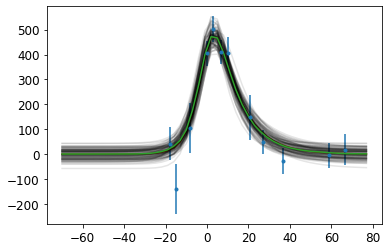

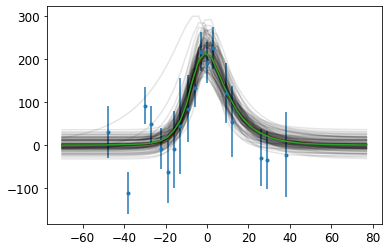

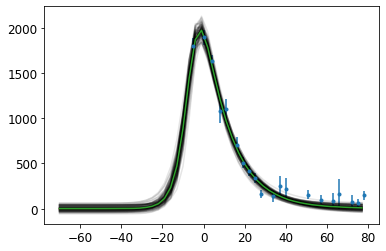

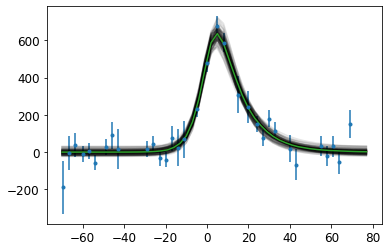

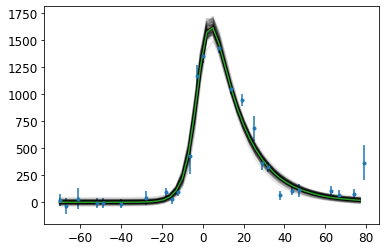

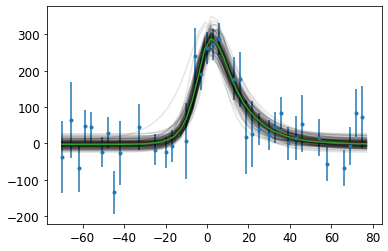

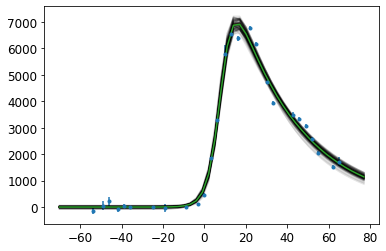

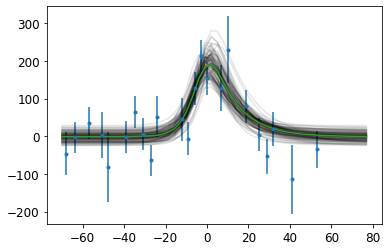

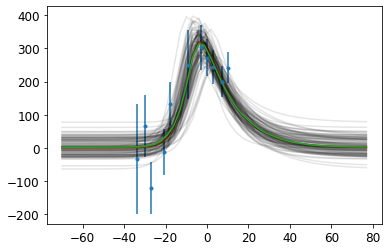

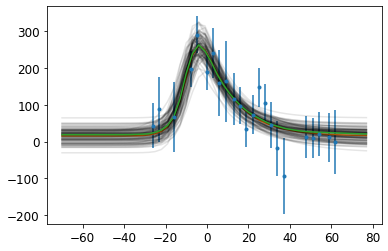

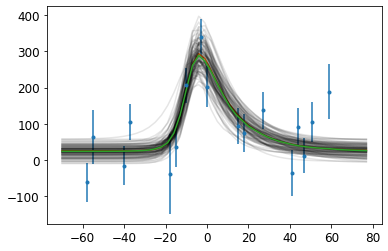

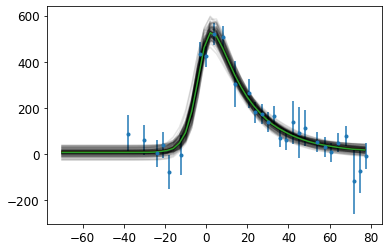

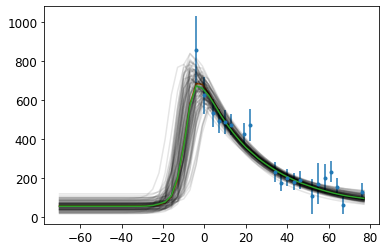

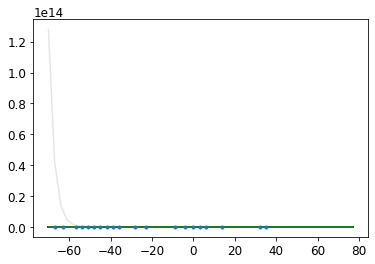

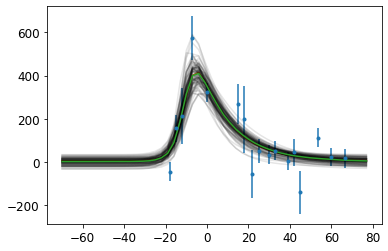

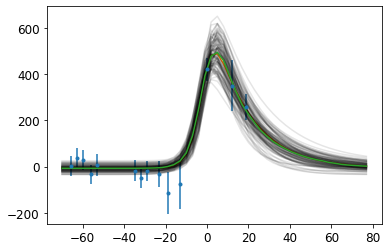

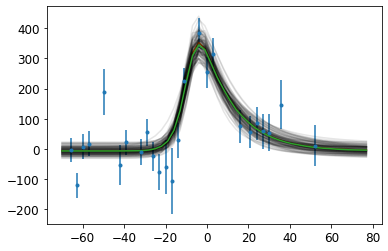

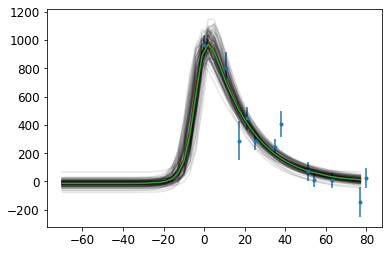

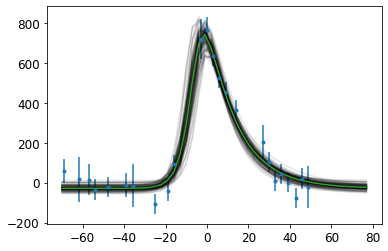

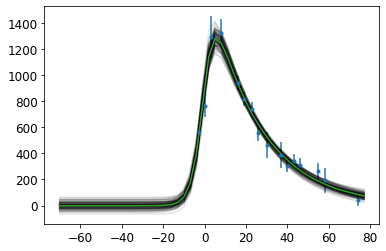

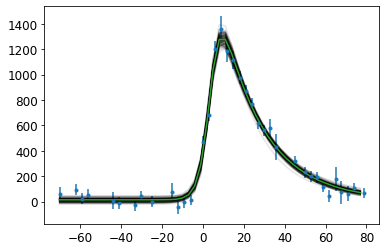

In [7]:
import warnings
from transomaly import helpers
import matplotlib
font = {'family': 'normal',
        'size': 12}
matplotlib.rc('font', **font)

# Initial values
fit_until = 80 
x0 = {classnum: {} for classnum in [1, 2, 3, 41, 51, 60, 64]}
x0[1]['g'] = np.array([ 1.48368249,  6.88499576,  0.01769543, -2.89894941, 13.00913707, -3.26870708])
x0[1]['r'] = np.array([ 1.72590238,  6.88990749, 13.33173975, -2.68888903, 18.0788523 , -3.20182138])
x0[2]['g'] = np.array([ 1.50242451,  6.68436755,  7.73427261, -4.7480326 , 16.95523111, -2.94116626])
x0[2]['r'] = np.array([ 2.16085158,  6.6371149 , 32.35952162, -2.65424337, 20.75961064, -2.9889291 ])
x0[3]['g'] = np.array([ 1.07777527,  6.54444294,  4.02360775, -4.54738533, 12.89964619, -3.192969  ])
x0[3]['r'] = np.array([ 1.75549099,  6.86362423, 19.11861163, -3.1259284 , 18.06485299, -3.12677127])
x0[41]['g'] = np.array([ 0.7593668 ,  6.20302338, -2.81322933, -4.75467927, 10.53034841, -3.17794844])
x0[41]['r'] = np.array([ 1.77460294,  7.11290321,  6.98898873, -3.69102185, 14.1378779 , -2.9605262 ])
x0[51]['g'] = np.array([  2.52034897,   6.33606602, -15.12960692,  -3.00983893,   8.20914977,  -2.88467834])
x0[51]['r'] = np.array([  3.10233746,   7.07399714, -10.21806295,  -1.66083924,   7.12625771,  -2.34761453])
x0[60]['g'] = np.array([ 2.88363436,  6.73653054, 62.82068497,  0.21939041, 20.99575862, -3.08524587])
x0[60]['r'] = np.array([ 3.61654735,  6.92662077, 79.45428496,  1.99960947, 22.55460852, -2.92490535])
x0[64]['g'] = np.array([ 2.94283772,  6.82558066, 47.73151297, -1.28252846, 21.70590852, -3.20017658])
x0[64]['r'] = np.array([ 2.39092078,  6.60697251, 42.0455873 , -0.79953415, 19.42144884, -3.19618455])


for class_num in [1, 2, 3, 41, 51, 60, 64]:
    print("Fitting Bazin params for class", class_num)
    passbands = ('g', 'r')
    nobjidx = len(light_curves_sims[class_num].items())

    save_bazin_params = {pb: {} for pb in passbands}
    for objidx, (objid, lc) in enumerate(light_curves_sims[class_num].items()):
        if objidx % 10 == 0: print(f"{objidx} of {nobjidx}", objid)
        if objidx not in np.random.randint(0, nobjidx, 10):
            continue
        try:
            time, flux, fluxerr, photflag = {}, {}, {}, {}
            for pb in passbands:
                pbmask = lc['passband'] == pb
                time[pb] = lc[pbmask]['time'].data
                flux[pb] = lc[pbmask]['flux'].data
                fluxerr[pb] = lc[pbmask]['fluxErr'].data
                photflag[pb] = lc[pbmask]['photflag'].data

                # Mask out times outside of mintime and maxtime
                timemask = (time[pb] > -70) & (time[pb] < 80)
                time[pb] = time[pb][timemask]
                flux[pb] = flux[pb][timemask]
                fluxerr[pb] = fluxerr[pb][timemask]
                photflag[pb] = photflag[pb][timemask]
                if np.max(flux[pb]) < 1e-5:
                    print(objidx, objid, "Low flux due to incorrect zeropoints")
                    continue

                # Optimise fit
                autograd_numpy = False
                def objective_func(theta):
                    if autograd_numpy:
                        np1 = autograd.numpy
                    else:
                        np1 = np

                    return -log_posterior(class_num, pb, time[pb], flux[pb], fluxerr[pb], fit_until, log_sigma_intrinsic=theta[0], logA=theta[1], B=theta[2], t0=theta[3], tau_fall=theta[4], tau_rise=theta[5], np=np1)

                res = minimize(objective_func, x0[class_num][pb], method='Nelder-Mead', options={'xtol': 1e-12, 'disp': False})
                # res = scipy.optimize.brute(objective_func, ((0,15), (50,20000), (-100, 1000), (-30, 40), (-30, 40), (-30, 40)))

                # print("Compute Covariance Matrix using Autograd")
                autograd_numpy = True
                hessian_ = autograd.hessian(objective_func)
                autograd_hessian_inv = lin.inv(hessian_(res.x))
                # print(autograd_hessian_inv)
                # Get Uncertaintites
                cov_matrix = autograd_hessian_inv
                sigmas = np.sqrt(np.diagonal(cov_matrix))
                # print(sigmas)

                # Save best values
                if np.any(np.isnan(sigmas)) or np.any(res.x == 0.0) or np.any(sigmas==0.0) or res.x[1] <= 0 or np.any(abs(res.x)<1e-4) or np.any(np.isnan(res.x)):
                    print(f"Bad fit for objid {objidx} {objid}. Params: {res.x} sigmas {sigmas}")
                    continue
                else:
                    save_bazin_params[pb][objid] = res.x

            
                # Plot draws
                fig = plt.figure()
                t_plot, y_pred_plot = get_y_pred(80, *res.x[1:])
                plt.errorbar(time[pb], flux[pb], yerr=fluxerr[pb], label='true - used for fitting', fmt='.')
                plt.plot(t_plot, y_pred_plot, label='pred')
                save_y_pred_draws = []
                for i in range(100):
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        param_draws = np.random.multivariate_normal(res.x, cov_matrix)
                    t_draw, y_pred_draw = get_y_pred(80, *param_draws[1:])
                    plt.plot(t_draw, y_pred_draw, color='black', alpha=0.1)
                    save_y_pred_draws.append(y_pred_draw)
                plt.plot(t_draw, np.median(save_y_pred_draws, axis=0), label='median draws')
                plt.text(0.6, 0.7, f"$negloglike = {round(np.max(negloglike, axis=0), 3)}$", horizontalalignment='left', verticalalignment='center', transform=fig.transFigure)
                plt.text(0.6, 0.6, f"$chi2 = {round(np.max(chi2, axis=0), 3)}$", horizontalalignment='left', verticalalignment='center', transform=fig.transFigure)
                plt.legend()
                plt.xlabel('Time in days')
                plt.ylabel(f'Flux {pb} band')
                plt.title(f"{objidx}  {objid}")
                plt.ylim(bottom=min(0, min(flux[pb]), min(y_pred_plot)), top=max(max(flux[pb]), max(y_pred_plot)))
                plt.show()
                plt.close()

                # # Print best fit parameters
                # print("\n")
                # print(f"log(sigma)    : initial={x0[class_num][pb][0]}, pred={res.x[0]:.2f} +- {sigmas[0]:.2f}")
                # print(f"log(A)        : initial={x0[class_num][pb][1]}, pred={res.x[1]:.2f} +- {sigmas[1]:.2f}")
                # print(f"B             : initial={x0[class_num][pb][2]}, pred={res.x[2]:.2f} +- {sigmas[2]:.2f}")
                # print(f"t0            : initial={x0[class_num][pb][3]}, pred={res.x[3]:.2f} +- {sigmas[3]:.2f}")
                # print(f"tau_fall      : initial={x0[class_num][pb][4]}, pred={res.x[4]:.2f} +- {sigmas[4]:.2f}")
                # print(f"tau_rise      : initial={x0[class_num][pb][5]}, pred={res.x[5]:.2f} +- {sigmas[5]:.2f}")

        
        except Exception as e:
            print(objidx, objid, e)
            continue


    # # with open('save_real_data_from_osc_bazin_params.pickle', 'wb') as f:
    # with open(f'save_bazin_params_class_multipb_{class_num}_190820.pickle', 'wb') as f:
    #     pickle.dump(save_bazin_params, f)


In [9]:
# Compare different classes bazin paramters as histograms
ndim = 6

for class_num in [1, 2, 3, 41, 51, 60, 64]:
    with open(f'save_bazin_params_class_multipb_{class_num}.pickle', 'rb') as f:
        load_bazin_params = pickle.load(f)
    for pb in passbands:
        params_array = np.array(list(load_bazin_params[pb].values()))

        # Using logA and logsigma
        labels = [r"$\log(\sigma)$", r"$\log(A)$", r"$B$", "$t_0$", r"$\tau_{fall}$", r"$\tau_{rise}$"]

        # Compute mean and covariance
        params_array_means = np.mean(params_array, axis=0)
        params_array_sigmas = np.std(params_array, axis=0)
        params_covariance = np.cov(params_array.T)
        print(f"if class_num == {repr(class_num)}:")
        print(f"    if passband == {repr(pb)}:")
        print(f"        means = np.{repr(params_array_means)}")
        print(f"        covariance = np.{repr(params_covariance)}")
        print(f"        inverse_covariance = np.{repr(lin.inv(np.median(params_array, axis=0)))}")
        # print(f"x0[{repr(class_num)}][{repr(pb)}] = np.{repr(params_array_means)}")
        
        # Plot histograms and remove 3 sigma outliers for plotting
        params_removed_outliers = []
        for i in range(ndim):
            params_removed_outliers.append(params_array[:,i][abs(params_array[:,i] - np.median(params_array[:,i])) < 3*np.std(params_array[:,i])])
            
        # print(params_array_means, params_array_sigmas)
        for i in range(ndim):
            fig = plt.figure(f"{i}_{pb}", figsize=(7,3.2))
            ax1 = plt.gca()
            ax1.hist(params_removed_outliers[i], bins=50, density=True, label=f"{helpers.get_sntypes()[class_num]}", alpha=0.3)
            ax1.set_xlabel(fr"{labels[i]} ${pb}$-band", fontsize=15)
            ax1.legend(fontsize=13)
            plt.xticks(fontsize=14)
            plt.yticks(fontsize=14)
            ax1.axes.yaxis.set_ticklabels([])
            plt.tight_layout()
            plt.savefig(f"{i}_{pb}")

if class_num == 1:
    if passband == 'g':
        means = np.array([ 1.48368249,  6.88499576,  0.01769543, -2.89894941, 13.00913707,
       -3.26870708])
        covariance = np.array([[ 1.97424818e+00,  6.69063745e-01, -2.75824049e+00,
         4.79123595e+00,  1.36153933e+00,  7.74497358e-02],
       [ 6.69063745e-01,  6.06286754e-01, -5.86940414e-01,
         2.25815100e+00,  6.36140478e-01,  5.66569800e-02],
       [-2.75824049e+00, -5.86940414e-01,  7.04335311e+02,
        -4.60383409e+00, -7.75393392e+00,  1.97318458e+00],
       [ 4.79123595e+00,  2.25815100e+00, -4.60383409e+00,
         2.98735655e+01,  3.38974238e+00, -4.38866926e-02],
       [ 1.36153933e+00,  6.36140478e-01, -7.75393392e+00,
         3.38974238e+00,  1.03628176e+01,  3.19107639e-01],
       [ 7.74497358e-02,  5.66569800e-02,  1.97318458e+00,
        -4.38866926e-02,  3.19107639e-01,  6.33997050e-02]])


LinAlgError: ignored

In [ ]:
#@title MCMC bazin fit to plasticc data
# ! pip install emcee
# ! pip install corner

import emcee
import corner

labels = ["sigma", "A", "B", "t0", "taufall", "taurise"]
pb = 'g'

save_bazin_params = {}
for objidx, (objid, lc) in enumerate(light_curves.items()):
    if objidx>3: break
    print(objidx, objid)
    try:
        pbmask = lc['passband'] == pb
        time = lc[pbmask]['time'].data
        flux = lc[pmask]['flux'].data
        fluxerr = lc[pbmask]['fluxErr'].data
        photflag = lc[pbmask]['photflag'].data

        # Mask out times outside of mintime and maxtime
        timemask = (time > -70) & (time < 80)
        time = time[timemask]
        flux = flux[timemask]
        fluxerr = fluxerr[timemask]
        photflag = photflag[timemask]

        def objective_func(theta):
            sigma_intrinsic = theta[0]
            if sigma_intrinsic < 0:
                return -np.inf
            return log_posterior(time, flux, fluxerr, fit_until, sigma_intrinsic=theta[0], A=theta[1], B=theta[2], t0=theta[3], tau_fall=theta[4], tau_rise=theta[5], np=np)


        pos = res.x + 1e-4 * np.random.randn(100, len(res.x))
        nwalkers, ndim = pos.shape
        print(nwalkers, ndim)

        sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_func)
        sampler.run_mcmc(pos, 2000, progress=True);
        samples = sampler.get_chain(discard=200, flat=True)

        # fig = corner.corner(samples, labels=labels, truths=res.x);

        # print mcmc 16th, 50th and 84th percentiles
        print("\nMCMC 16th, 50th, and 84th percentiles")
        badfit = False
        param_vals = []
        for i in range(ndim):
            mcmc = np.percentile(samples[:, i], [16, 50, 84])
            q = np.diff(mcmc)
            txt = f"{labels[i]} = {mcmc[1]:.2f} (+{q[0]:.2f}) (-{q[1]:.2f})"
            print(txt)
            param_vals.append(mcmc[1])
            if q[0] > 1e5 or q[1] > 1e5:
                print("Bad fit for", objid, i, q[0], q[1])
                badfit = True
                break
        if badfit:
            continue

        # Save best values
        save_bazin_params[objid] = param_vals

        # Plot draws
        plt.figure()
        t_plot, y_pred_plot = get_y_pred(80, *res.x[1:])
        # plt.errorbar(t_all, y_data_all, yerr=yerr_all, label='true - not used for fitting', fmt='.')
        plt.errorbar(time, flux, yerr=fluxerr, label='true - used for fitting', fmt='.')
        plt.plot(t_plot, y_pred_plot, label='pred')
        plt.axvspan(t_all[np.argmax(t_data)+1], max(t_all), alpha=0.2, color='grey')
        save_y_pred_draws = []
        for i in range(100):
            sample_idx = np.random.randint(low=0, high=samples.shape[0])
            t_draw, y_pred_draw = get_y_pred(80, *samples[sample_idx][1:])
            plt.plot(t_draw, y_pred_draw, color='black', alpha=0.1)
            save_y_pred_draws.append(y_pred_draw)
        plt.plot(t_draw, np.median(save_y_pred_draws, axis=0), label='median draws')
        plt.legend()
        plt.xlabel('Time in days')
        plt.ylabel('Flux')
        plt.title(f"{objidx}  {objid}")
        plt.show()
        # plt.ylim(bottom=-10, top=70)

    except Exception as e:
        print(i, objid, e)
        continue

# import pickle
# with open('save_bazin_params.pickle', 'wb') as f:
#     pickle.dump(save_bazin_params, f)





[[ 1.67688598e+00  7.00193077e-01  8.82353489e+00  4.48695226e+00
   1.34176611e+00  9.54228266e-02]
 [ 7.00193077e-01  5.18863319e-01  5.49978380e+00  1.93237147e+00
   6.79978370e-01  6.69419004e-02]
 [ 8.82353489e+00  5.49978380e+00  9.87234313e+02  1.99810737e+01
   1.02740660e+01  3.95703621e+00]
 [ 4.48695226e+00  1.93237147e+00  1.99810737e+01  2.73745511e+01
   2.26234792e+00 -5.02746297e-02]
 [ 1.34176611e+00  6.79978370e-01  1.02740660e+01  2.26234792e+00
   1.44470075e+01  5.25918018e-01]
 [ 9.54228266e-02  6.69419004e-02  3.95703621e+00 -5.02746297e-02
   5.25918018e-01  7.75918070e-02]]
[[ 1.62035102e+00  3.95858098e-01  4.55181800e+01  1.64692498e+00
   8.08509351e-01  2.55326872e-01]
 [ 3.95858098e-01  3.34968922e-01  1.42534989e+01  1.42010444e+00
  -1.21029900e-02  1.40085107e-01]
 [ 4.55181800e+01  1.42534989e+01  6.90890382e+03 -2.03177443e+00
   7.78310079e+01  2.54188001e+01]
 [ 1.64692498e+00  1.42010444e+00 -2.03177443e+00  3.18961712e+01
  -9.37891960e+00 -8.277

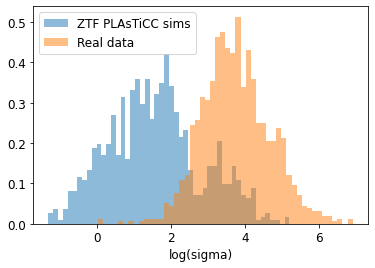

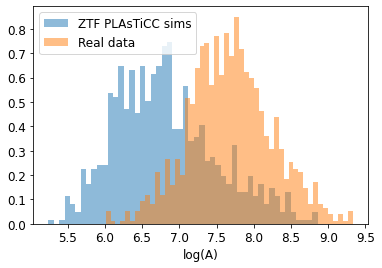

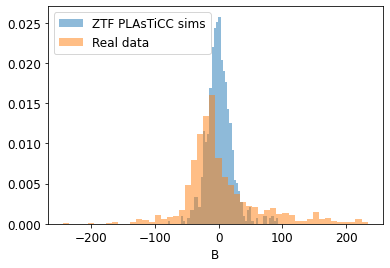

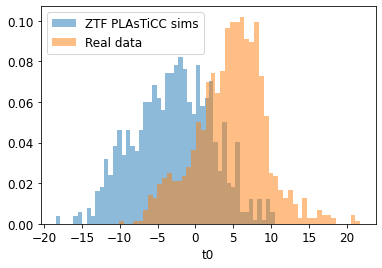

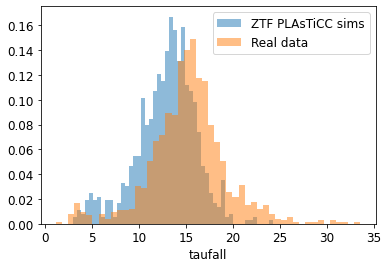

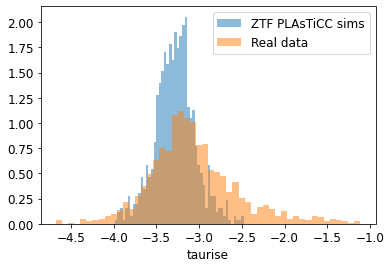

In [10]:
# Compare real data to simulated data for SNIa

ndim = 6

with open('save_bazin_params.pickle', 'rb') as f:
    load_bazin_params = pickle.load(f)
params_array = np.array(list(load_bazin_params.values()))
#
with open('save_real_data_from_osc_bazin_params.pickle', 'rb') as f:
    load_bazin_params2 = pickle.load(f)
params_array2 = np.array(list(load_bazin_params2.values()))

# Change to logA and logsigma
labels = ["log(sigma)", "log(A)", "B", "t0", "taufall", "taurise"]
params_array[:,0] = np.log(params_array[:,0])
params_array[:,1] = np.log(params_array[:,1])
#
params_array2[:,0] = np.log(params_array2[:,0])
params_array2[:,1] = np.log(params_array2[:,1])

# Compute mean and covariance
params_array_means = np.mean(params_array, axis=0)
params_array_sigmas = np.std(params_array, axis=0)
params_covariance = np.cov(params_array.T)
print(params_covariance)
#
params_array_means2 = np.mean(params_array2, axis=0)
params_array_sigmas2 = np.std(params_array2, axis=0)
params_covariance2 = np.cov(params_array2.T)
print(params_covariance2)

# Plot histograms and remove 3 sigma outliers for plotting
params_removed_outliers = []
for i in range(ndim):
    params_removed_outliers.append(params_array[:,i][abs(params_array[:,i] - np.median(params_array[:,i])) < 3*np.std(params_array[:,i])])
#
params_removed_outliers2 = []
for i in range(ndim):
    params_removed_outliers2.append(params_array2[:,i][abs(params_array2[:,i] - np.median(params_array2[:,i])) < 3*np.std(params_array2[:,i])])
    
print(params_array_means, params_array_sigmas)
for i in range(ndim):
    plt.figure()
    plt.hist(params_removed_outliers[i], bins=50, density=True, label="ZTF PLAsTiCC sims", alpha=0.5)
    plt.hist(params_removed_outliers2[i], bins=50, density=True, label='Real data', alpha=0.5)
    plt.xlabel(labels[i])
    plt.legend()
    

In [11]:
# # np.where(~np.isfinite(params_array))
# params_covariance
# params_array_means
params_array

array([[  1.07155992,   6.61079679,  11.46072304,  -3.27483404,
         13.30719614,  -3.2334255 ],
       [ -1.19430324,   5.56718612,  -0.11615719, -14.99046434,
         13.51690962,  -3.1360463 ],
       [  1.1681499 ,   6.63920666,  15.26886401,  -2.09902503,
          5.72072845,  -3.05672657],
       ...,
       [  2.10013863,   7.42822359,  16.91507816,  -2.80719248,
         18.77679876,  -3.31564439],
       [  1.29989566,   6.71769099, -35.53277016,  -4.8798902 ,
         13.97101997,  -3.33244211],
       [  3.09097613,   6.77501744,  60.86896214,  -3.65759237,
          3.76393474,  -3.32570912]])

In [ ]:
params_covariance
np.linalg.inv(params_covariance)
# params_array_means
# np.median(fluxerr)

In [ ]:
#@title Check univariate vs multivariate gaussian priors

# x = np.array([sigma_intrinsic, A, B, t0, tau_fall, tau_rise])
# means = np.array([24.9723914 , 890.8069568 , -26.34104599,  -3.4609063 ,
#                   16.20697774,  -3.40826335])
# covariance = np.array([[ 1.74474637e+02,  2.18543822e+03, -2.70052169e+02,
#                           7.41085359e+00,  1.41350541e+01, -1.71021825e+00],
#                         [ 2.18543822e+03,  2.88251062e+05, -9.25276312e+04,
#                           6.59647012e+02,  2.79607128e+03, -3.53338108e+02],
#                         [-2.70052169e+02, -9.25276312e+04,  6.81433971e+04,
#                           5.16278048e+02, -2.50140730e+03,  2.49325353e+02],
#                         [ 7.41085359e+00,  6.59647012e+02,  5.16278048e+02,
#                           4.14864470e+01, -3.13248842e+01,  1.02721038e+00],
#                         [ 1.41350541e+01,  2.79607128e+03, -2.50140730e+03,
#                           -3.13248842e+01,  1.17189022e+02, -9.34560249e+00],
#                         [-1.71021825e+00, -3.53338108e+02,  2.49325353e+02,
#                           1.02721038e+00, -9.34560249e+00,  1.72261655e+00]])
# n = len(means)
# inverse_covariance = np.array([[6.78744316e-03, -9.29642223e-05, -2.28506150e-04,
#                                     8.05930286e-04, -2.90254365e-03,  4.51563295e-03],
#                                   [-9.29642223e-05,  1.01991443e-05,  2.03397428e-05,
#                                     -3.17739063e-04,  1.00292910e-04, -2.10594624e-04],
#                                   [-2.28506150e-04,  2.03397428e-05,  1.24103770e-04,
#                                     -4.10170214e-04,  1.73313886e-03, -4.36989143e-03],
#                                   [ 8.05930286e-04, -3.17739063e-04, -4.10170214e-04,
#                                     4.35185650e-02,  1.39113687e-02,  4.45149742e-02],
#                                   [-2.90254365e-03,  1.00292910e-04,  1.73313886e-03,
#                                     1.39113687e-02,  4.92597661e-02,  2.57922494e-02],
#                                   [ 4.51563295e-03, -2.10594624e-04, -4.36989143e-03,
#                                     4.45149742e-02,  2.57922494e-02,  1.28766568e+00]])
# log_prior = -(n/2)*np.log(2*np.pi) - 0.5*np.log(np.linalg.det(covariance)) - 0.5 * (x-means) @ inverse_covariance @ (x-means)
# print(log_prior)

# sigma_intrinsic, A, B, t0, tau_fall, tau_rise = x
# # sigma_intrinsic prior
# sigma_intrinsic_mean = means[0]
# sigma_intrinsic_sigma = np.sqrt(np.diagonal(covariance)[0])
# sigma_log_prior = -0.5*np.log(2*np.pi*sigma_intrinsic_sigma**2)-0.5*(sigma_intrinsic-sigma_intrinsic_mean)**2/sigma_intrinsic_sigma**2

# # A prior
# A_mean = means[1]
# A_sigma = np.sqrt(np.diagonal(covariance)[1])
# A_log_prior = -0.5*np.log(2*np.pi*A_sigma**2)-0.5*(A-A_mean)**2/A_sigma**2

# # B prior
# B_mean = means[2]
# B_sigma = np.sqrt(np.diagonal(covariance)[2])
# B_log_prior = -0.5*np.log(2*np.pi*B_sigma**2)-0.5*(B-B_mean)**2/B_sigma**2

# # t0 prior
# t0_mean = means[3]
# t0_sigma = np.sqrt(np.diagonal(covariance)[3])
# t0_log_prior = -0.5*np.log(2*np.pi*t0_sigma**2)-0.5*(t0-t0_mean)**2/t0_sigma**2

# # tau_fall prior
# tau_fall_mean = means[4]
# tau_fall_sigma = np.sqrt(np.diagonal(covariance)[4])
# tau_fall_log_prior = -0.5*np.log(2*np.pi*tau_fall_sigma**2)-0.5*(tau_fall-tau_fall_mean)**2/tau_fall_sigma**2

# # tau_rise prior
# tau_rise_mean = means[5]
# tau_rise_sigma = np.sqrt(np.diagonal(covariance)[5])
# tau_rise_log_prior = -0.5*np.log(2*np.pi*tau_rise_sigma**2)-0.5*(tau_rise-tau_rise_mean)**2/tau_rise_sigma**2

# log_prior = np.log(1) + sigma_log_prior + A_log_prior + B_log_prior + tau_fall_log_prior + tau_rise_log_prior
# print(log_prior)



-1.4941149543313714 6.462639541553349 -29.266289715562593 -2.8801525721670704 16.738120320287734 -3.470076377966222
         Current function value: 195.363281
         Iterations: 42
         Function evaluations: 385
         Gradient evaluations: 48
Get Inverse Hessian from BFGS optimiser
[[ 0.11156123 -0.00277267 -0.07011436 -0.04479098  0.02770606  0.00806314]
 [-0.00277267  0.00031051  0.00372373  0.00278548 -0.00518599 -0.00013104]
 [-0.07011436  0.00372373  0.06933188  0.05083178 -0.06827103 -0.00691261]
 [-0.04479098  0.00278548  0.05083178  0.0482083  -0.05455124 -0.00817685]
 [ 0.02770606 -0.00518599 -0.06827103 -0.05455124  0.1159621   0.00336558]
 [ 0.00806314 -0.00013104 -0.00691261 -0.00817685  0.00336558  0.00273328]]
Compute Inverse Hessian using Autograd
[[ 3.86987337e-01 -3.12760764e-03  1.24945056e-01 -3.64502149e-02
   5.69288808e-02  7.38251264e-03]
 [-3.12760764e-03  2.71752691e-04  2.75136549e-03  2.18145534e-03
  -5.60976230e-03  2.12892522e-05]
 [ 1.24945056e-

(-62.72506812276535, 363.7794894860713)

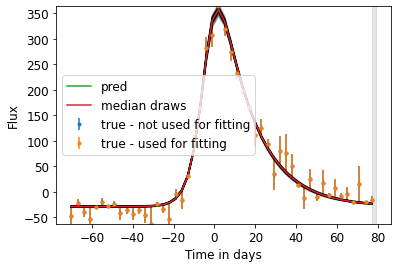

In [12]:
np.random.seed(42)

# Make dataset
t_all = np.arange(-70,80,step=3)
# sigma_intrinsic = np.random.normal(25, 13)  # 5
# A = np.random.normal(891, 536)  # 100
# B = np.random.normal(-26, 260)  # 
# t0 = np.random.normal(-3.5, 6.4)  # 
# tau_fall = np.random.normal(16.2, 10.8)  # 20
# tau_rise = np.random.normal(-3.4, 1.3)  # -6
# print(sigma_intrinsic, A, B, t0, tau_fall, tau_rise)
data_means = np.array([ 1.70522369,  6.83039727,  3.60728806, -2.72013241, 13.69171025, -3.21985621])
data_covariance = np.array([[7.49096627e+00, 9.01726007e-01, 2.66965110e+01, 8.27519610e+00,
                          3.22998697e+00, 3.02413974e-01],
                        [9.01726007e-01, 5.39866858e-01, 7.91625228e+00, 2.27039763e+00,
                          6.59346887e-01, 8.90609190e-02],
                        [2.66965110e+01, 7.91625228e+00, 4.34861842e+03, 1.73073597e+02,
                          1.03490513e+02, 1.94038357e+01],
                        [8.27519610e+00, 2.27039763e+00, 1.73073597e+02, 4.59726855e+01,
                          5.14228861e+00, 4.92809317e-01],
                        [3.22998697e+00, 6.59346887e-01, 1.03490513e+02, 5.14228861e+00,
                          2.96042102e+01, 1.33934350e+00],
                        [3.02413974e-01, 8.90609190e-02, 1.94038357e+01, 4.92809317e-01,
                          1.33934350e+00, 2.90804476e-01]])
log_sigma_intrinsic, logA, B, t0, tau_fall, tau_rise = np.random.multivariate_normal(data_means, data_covariance)
print(log_sigma_intrinsic, logA, B, t0, tau_fall, tau_rise)
fit_until = 79  # 30
t_data, y_data, yerr, t_all, y_data_all, yerr_all = get_y_data(fit_until, np.exp(log_sigma_intrinsic), np.exp(logA), B, t0, tau_fall, tau_rise, seed=0, t_all=t_all)
class_num = 1
pb = 'g'

autograd_numpy = False

# Optimise
def objective_func(theta):
    if autograd_numpy:
        np1 = autograd.numpy
    else:
        np1 = np

    return -log_posterior(class_num, pb, t_data, y_data, yerr, fit_until, log_sigma_intrinsic=theta[0], logA=theta[1], B=theta[2], t0=theta[3], tau_fall=theta[4], tau_rise=theta[5], np=np1)

res = minimize(objective_func, x0=data_means, method='BFGS', options={'disp': True})

# Compute hessian in two ways
print("Get Inverse Hessian from BFGS optimiser")
hessian_inv = res.hess_inv
print(hessian_inv)
print("Compute Inverse Hessian using Autograd")
autograd_numpy = True
hessian_ = autograd.hessian(objective_func)
autograd_hessian_inv = lin.inv(hessian_(res.x))
print(autograd_hessian_inv)

# Get Uncertaintites
cov_matrix = autograd_hessian_inv
sigmas = np.sqrt(np.diagonal(cov_matrix))
print(sigmas)


# Print comparisons
print("\n")
print(f"log(sigma)    : true={log_sigma_intrinsic},   pred={res.x[0]:.2f} +- {sigmas[0]:.2f}")
print(f"log(A)        : true={logA}, pred={res.x[1]:.2f} +- {sigmas[1]:.2f}")
print(f"B             : true={B},   pred={res.x[2]:.2f} +- {sigmas[2]:.2f}")
print(f"t0            : true={t0},  pred={res.x[3]:.2f} +- {sigmas[3]:.2f}")
print(f"tau_fall      : true={tau_fall},  pred={res.x[4]:.2f} +- {sigmas[4]:.2f}")
print(f"tau_rise      : true={tau_rise},  pred={res.x[5]:.2f} +- {sigmas[5]:.2f}")


# Plot
t_plot, y_pred_plot = get_y_pred(80, *res.x[1:])
plt.errorbar(t_all, y_data_all, yerr=yerr_all, label='true - not used for fitting', fmt='.')
plt.errorbar(t_data, y_data, yerr=yerr, label='true - used for fitting', fmt='.')
plt.plot(t_plot, y_pred_plot, label='pred')
plt.axvspan(fit_until, max(t_all), alpha=0.2, color='grey')

# Draw random parameter functions
save_y_pred_draws = []
for i in range(100):
    param_draws = np.random.multivariate_normal(res.x, cov_matrix)
    t_draw, y_pred_draw = get_y_pred(80, *param_draws[1:])
    plt.plot(t_draw, y_pred_draw, color='black', alpha=0.1)
    save_y_pred_draws.append(y_pred_draw)
plt.plot(t_draw, np.median(save_y_pred_draws, axis=0), label='median draws')

plt.legend()
plt.xlabel('Time in days')
plt.ylabel('Flux')
plt.ylim(bottom=min(y_data_all), top=max(y_data_all))

  1%|          | 6/1000 [00:00<00:16, 59.25it/s]

100 6


100%|██████████| 1000/1000 [00:15<00:00, 65.36it/s]



MCMC 16th, 50th, and 84th percentiles
log(sigma) = 0.28 (+0.64) (-0.53)
log(A) = 6.46 (+0.02) (-0.02)
B = -28.94 (+0.80) (-0.90)
t0 = -3.10 (+0.24) (-0.23)
taufall = 16.97 (+0.42) (-0.46)
taurise = -3.43 (+0.06) (-0.07)

MLE with sigmas from inverse Hessian
log(sigma)    : true=-1.4941149543313714,   pred=-0.31 +- 0.62
log(A)        : true=6.462639541553349, pred=6.46 +- 0.02
B             : true=-29.266289715562593,   pred=-29.10 +- 0.66
t0            : true=-2.8801525721670704,  pred=-3.02 +- 0.20
tau_fall      : true=16.738120320287734,  pred=16.88 +- 0.38
tau_rise      : true=-3.470076377966222,  pred=-3.45 +- 0.05


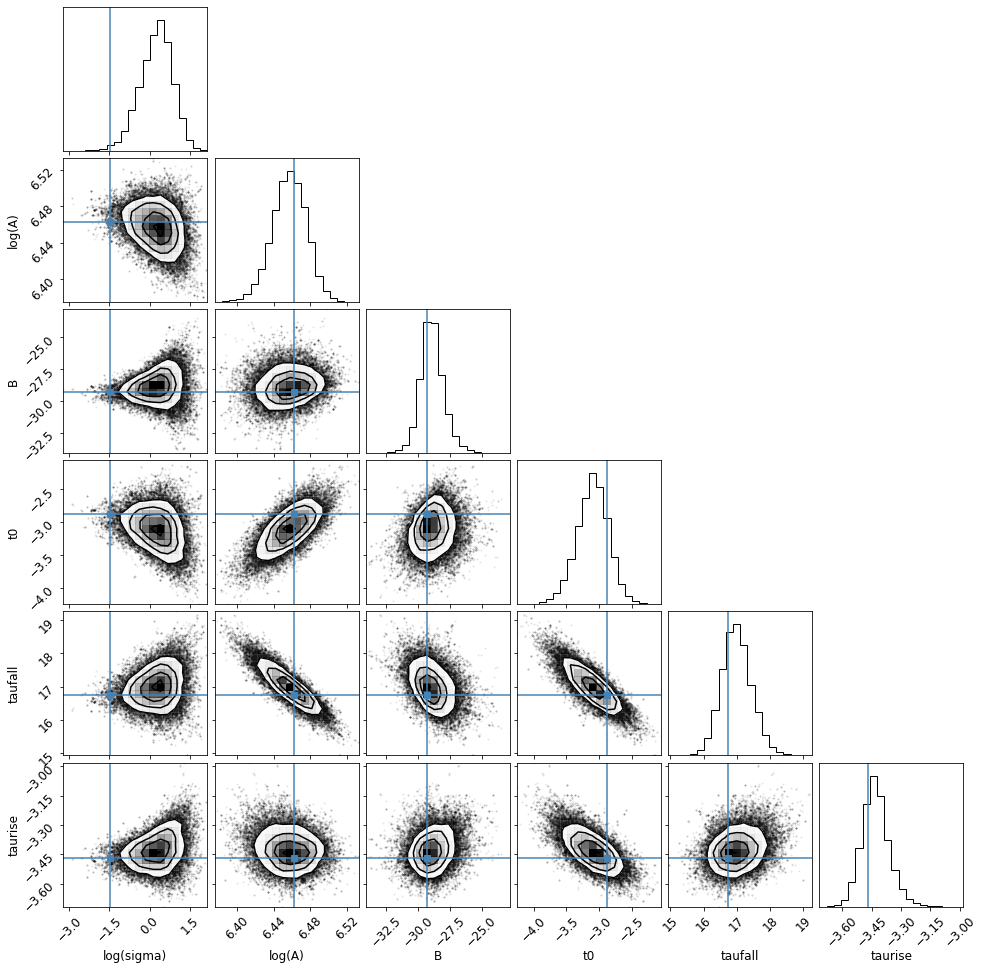

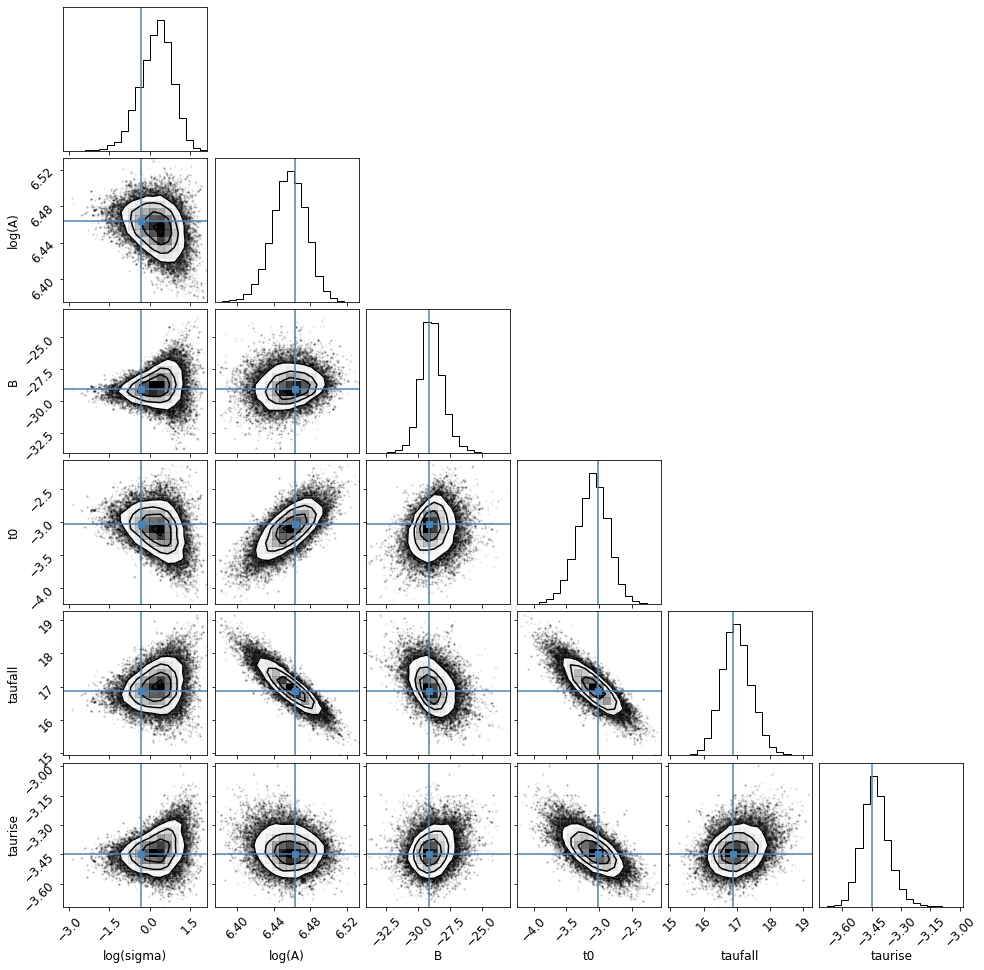

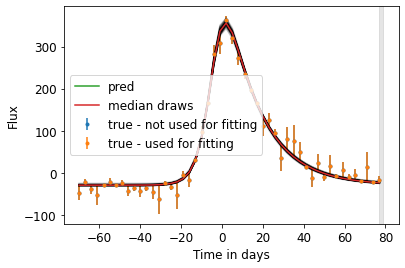

In [13]:
# ## MCMC fit
# ! pip install emcee
# ! pip install corner
# ! pip install chainconsumer
labels = ["log(sigma)", "log(A)", "B", "t0", "taufall", "taurise"]
def objective_func(theta):
    # return log_posterior(class_num, pb, time, flux, fluxerr, fit_until, log_sigma_intrinsic=theta[0], logA=theta[1], B=theta[2], t0=theta[3], tau_fall=theta[4], tau_rise=theta[5], np=np)
    return log_posterior(class_num, pb, t_data, y_data, yerr, fit_until, log_sigma_intrinsic=theta[0], logA=theta[1], B=theta[2], t0=theta[3], tau_fall=theta[4], tau_rise=theta[5], np=np)


import emcee
import corner

pos = res.x + 1e-4 * np.random.randn(100, len(res.x))
nwalkers, ndim = pos.shape
print(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_func)
sampler.run_mcmc(pos, 1000, progress=True);
samples = sampler.get_chain(discard=200, flat=True)

fig = corner.corner(samples, labels=labels, truths=[log_sigma_intrinsic, logA, B, t0, tau_fall, tau_rise]);

fig = corner.corner(samples, labels=labels, truths=res.x);

# print mcmc 16th, 50th and 84th percentiles
print("\nMCMC 16th, 50th, and 84th percentiles")
for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = f"{labels[i]} = {mcmc[1]:.2f} (+{q[0]:.2f}) (-{q[1]:.2f})"
    print(txt)

# Plot draws
plt.figure()
t_plot, y_pred_plot = get_y_pred(80, *res.x[1:])
plt.errorbar(t_all, y_data_all, yerr=yerr_all, label='true - not used for fitting', fmt='.')
plt.errorbar(t_data, y_data, yerr=yerr, label='true - used for fitting', fmt='.')
# plt.errorbar(time, flux, yerr=fluxerr, label='true - used for fitting', fmt='.')
plt.plot(t_plot, y_pred_plot, label='pred')
plt.axvspan(fit_until, max(t_all), alpha=0.2, color='grey')
save_y_pred_draws = []
for i in range(100):
    sample_idx = np.random.randint(low=0, high=samples.shape[0])
    t_draw, y_pred_draw = get_y_pred(80, *samples[sample_idx][1:])
    plt.plot(t_draw, y_pred_draw, color='black', alpha=0.1)
    save_y_pred_draws.append(y_pred_draw)
plt.plot(t_draw, np.median(save_y_pred_draws, axis=0), label='median draws')
plt.legend()
plt.xlabel('Time in days')
plt.ylabel('Flux')
# plt.ylim(bottom=-10, top=70)

print("\nMLE with sigmas from inverse Hessian")
print(f"log(sigma)    : true={log_sigma_intrinsic},   pred={res.x[0]:.2f} +- {sigmas[0]:.2f}")
print(f"log(A)        : true={logA}, pred={res.x[1]:.2f} +- {sigmas[1]:.2f}")
print(f"B             : true={B},   pred={res.x[2]:.2f} +- {sigmas[2]:.2f}")
print(f"t0            : true={t0},  pred={res.x[3]:.2f} +- {sigmas[3]:.2f}")
print(f"tau_fall      : true={tau_fall},  pred={res.x[4]:.2f} +- {sigmas[4]:.2f}")
print(f"tau_rise      : true={tau_rise},  pred={res.x[5]:.2f} +- {sigmas[5]:.2f}")


In [ ]:
#@title Fit Bazin simulations at multiple time steps single passband

for fit_until in range(-70, 80, 3):
    t_data, y_data, yerr, t_all, y_data_all, yerr_all = get_y_data(fit_until, np.exp(log_sigma_intrinsic), np.exp(logA), B, t0, tau_fall, tau_rise, seed=0, t_all=t_all)
    
    def objective_func(theta):
        if autograd_numpy:
            np1 = autograd.numpy
        else:
            np1 = np

        return -log_posterior(t_data, y_data, yerr, fit_until, log_sigma_intrinsic=theta[0], logA=theta[1], B=theta[2], t0=theta[3], tau_fall=theta[4], tau_rise=theta[5], np=np1)

    res = minimize(objective_func, x0, method='BFGS', options={'xatol': 1e-8, 'disp': True})

    # Compute hessian in two ways
    # print("Compute Inverse Hessian using Autograd")
    autograd_numpy = True
    hessian_ = autograd.hessian(objective_func)
    autograd_hessian_inv = lin.inv(hessian_(res.x))
    # print(autograd_hessian_inv)

    # Get Uncertaintites
    cov_matrix = autograd_hessian_inv
    sigmas = np.sqrt(np.diagonal(cov_matrix))
    print(sigmas)
    if np.any(np.isnan(cov_matrix)):
        print("covariance matrix has nans", fit_until, cov_matrix)
        continue

    t_plot, y_pred_plot = get_y_pred(80, *res.x[1:])

    plt.figure()
    plt.errorbar(t_all, y_data_all, yerr=yerr_all, label='true - not used for fitting', fmt='.')
    plt.errorbar(t_data, y_data, yerr=yerr, label='true - used for fitting', fmt='.')
    plt.plot(t_plot, y_pred_plot, label='pred')
    plt.axvspan(fit_until, max(t_all), alpha=0.2, color='grey')

    # Draw random parameter functions
    save_y_pred_draws = []
    for i in range(100):
        param_draws = np.random.multivariate_normal(res.x, cov_matrix)
        t_draw, y_pred_draw = get_y_pred(80, *param_draws[1:])
        plt.plot(t_draw, y_pred_draw, color='black', alpha=0.1)
        save_y_pred_draws.append(y_pred_draw)
    plt.plot(t_draw, np.median(save_y_pred_draws, axis=0), label='median draws')

    plt.legend()
    plt.xlabel('Time in days')
    plt.ylabel('Flux')
    plt.ylim(bottom=min(y_data_all), top=max(y_data_all))
    plt.show()


    # Print comparisons
    print("\n")
    print(fit_until)
    print(f"log(sigma)    : true={log_sigma_intrinsic},   pred={res.x[0]:.2f} +- {sigmas[0]:.2f}")
    print(f"log(A)        : true={logA}, pred={res.x[1]:.2f} +- {sigmas[1]:.2f}")
    print(f"B             : true={B},   pred={res.x[2]:.2f} +- {sigmas[2]:.2f}")
    print(f"t0            : true={t0},  pred={res.x[3]:.2f} +- {sigmas[3]:.2f}")
    print(f"tau_fall      : true={tau_fall},  pred={res.x[4]:.2f} +- {sigmas[4]:.2f}")
    print(f"tau_rise      : true={tau_rise},  pred={res.x[5]:.2f} +- {sigmas[5]:.2f}")



0 of 11962 1_101998576
objidx: 0, timestep: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in multiply
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


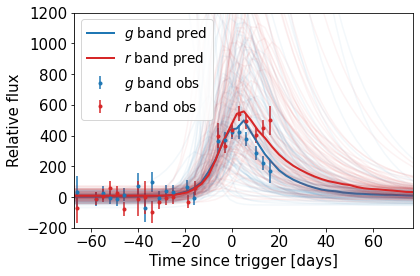

objidx: 0, timestep: 1


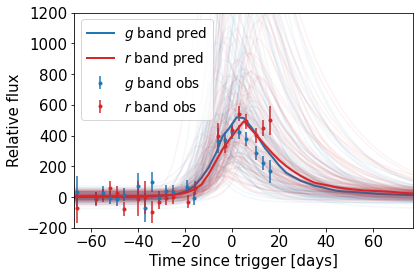

objidx: 0, timestep: 2


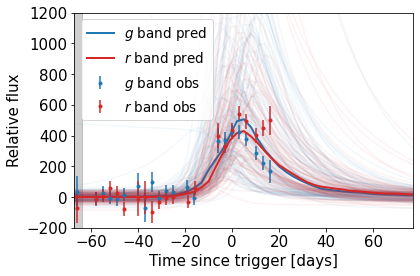

objidx: 0, timestep: 3


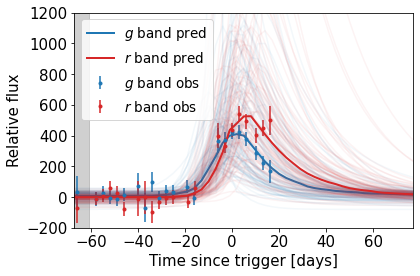

objidx: 0, timestep: 4


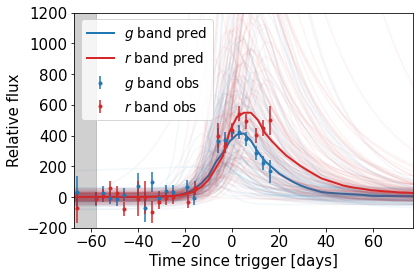

objidx: 0, timestep: 5


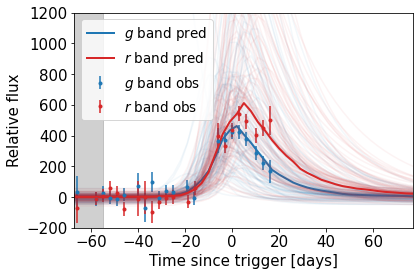

objidx: 0, timestep: 6


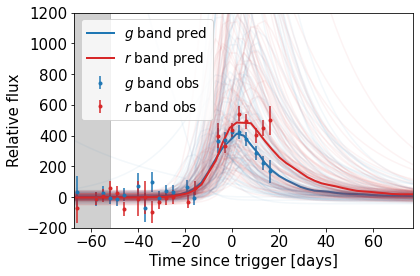

objidx: 0, timestep: 7


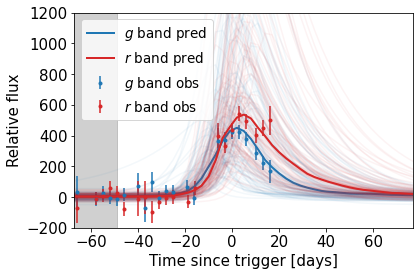

objidx: 0, timestep: 8


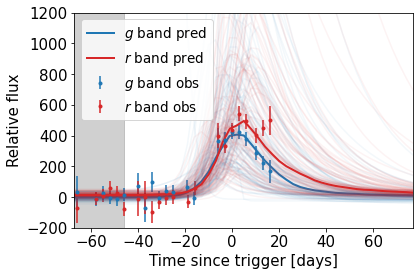

objidx: 0, timestep: 9


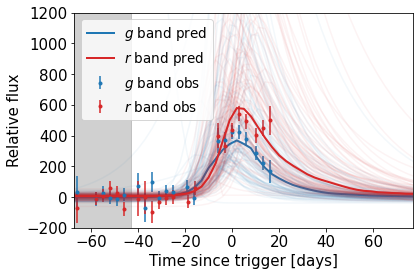

objidx: 0, timestep: 10


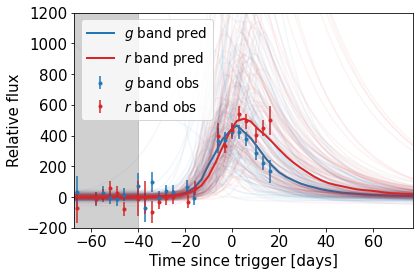

objidx: 0, timestep: 11


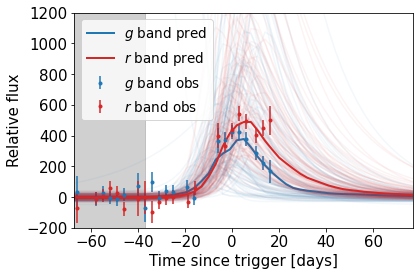

objidx: 0, timestep: 12


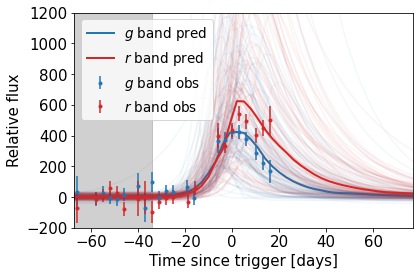

objidx: 0, timestep: 13


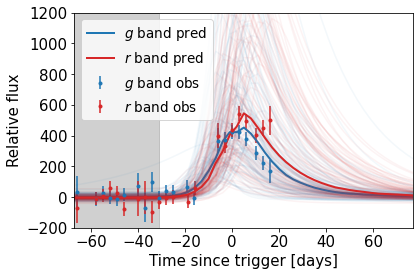

objidx: 0, timestep: 14


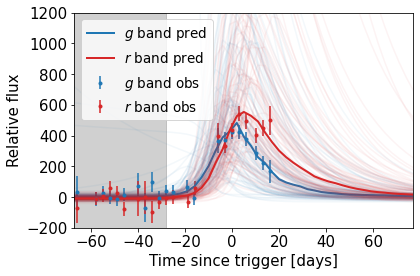

objidx: 0, timestep: 15


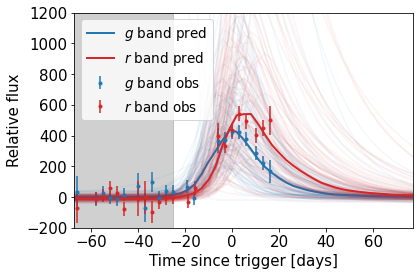

objidx: 0, timestep: 16


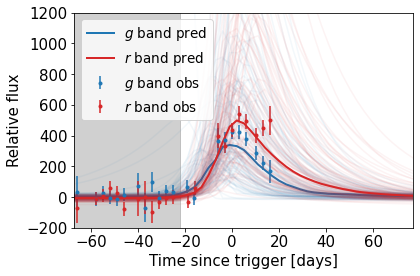

objidx: 0, timestep: 17


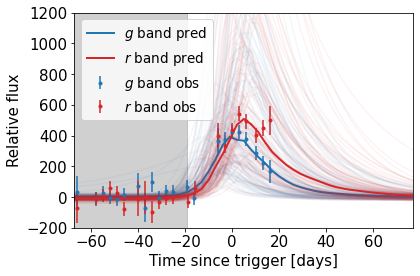

objidx: 0, timestep: 18


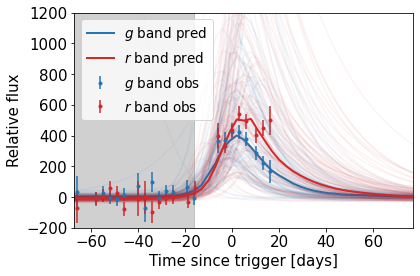

objidx: 0, timestep: 19


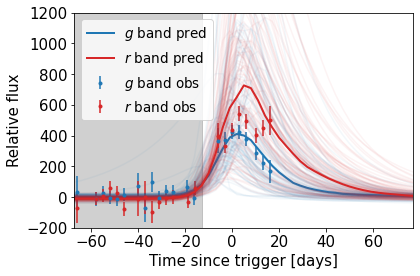

objidx: 0, timestep: 20


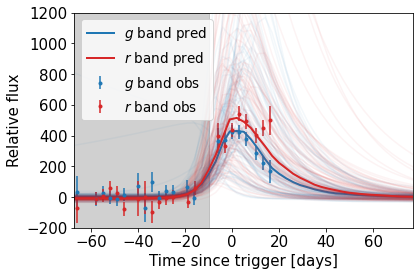

objidx: 0, timestep: 21


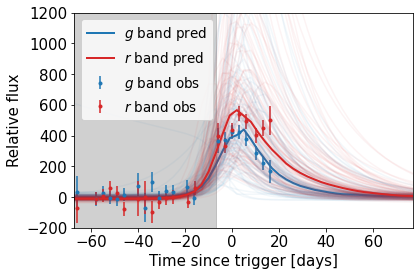

objidx: 0, timestep: 22


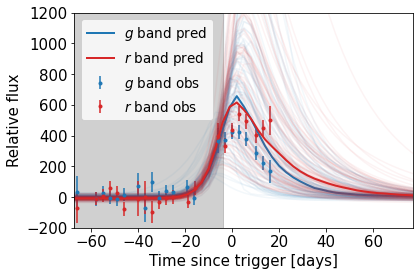

objidx: 0, timestep: 23


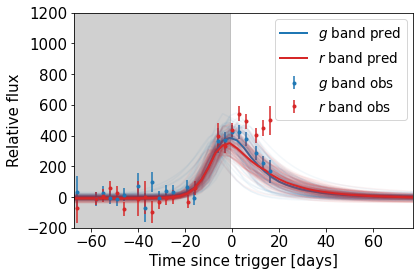

objidx: 0, timestep: 24


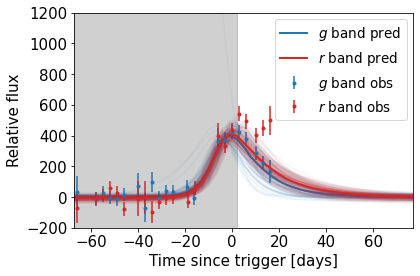

objidx: 0, timestep: 25


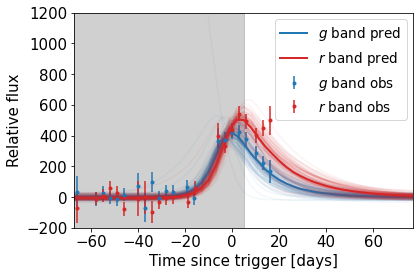

objidx: 0, timestep: 26


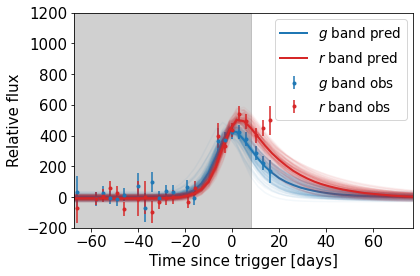

objidx: 0, timestep: 27


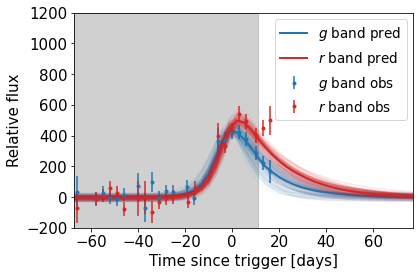

objidx: 0, timestep: 28


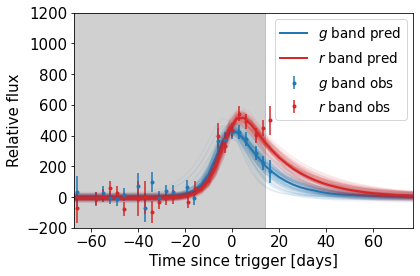

objidx: 0, timestep: 29


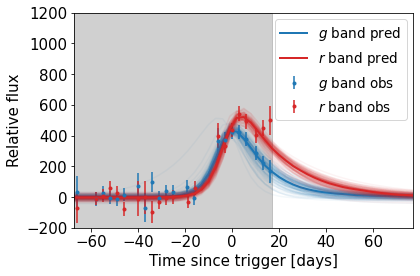

objidx: 0, timestep: 30


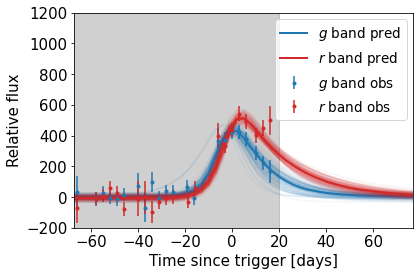

objidx: 0, timestep: 31


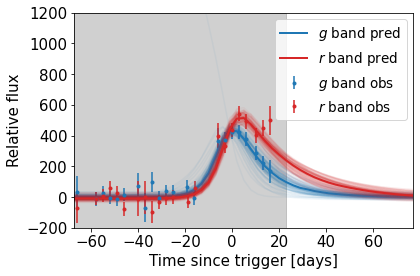

objidx: 0, timestep: 32


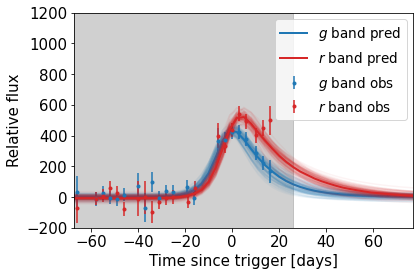

objidx: 0, timestep: 33


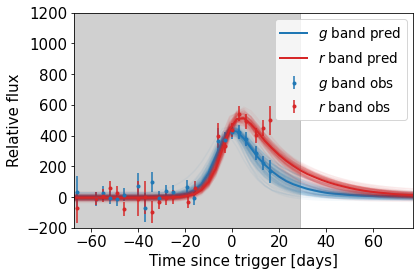

objidx: 0, timestep: 34


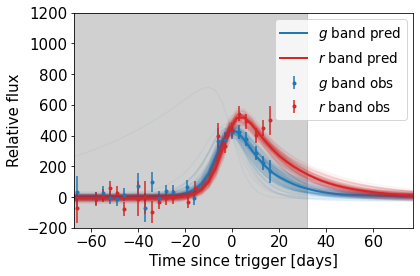

objidx: 0, timestep: 35


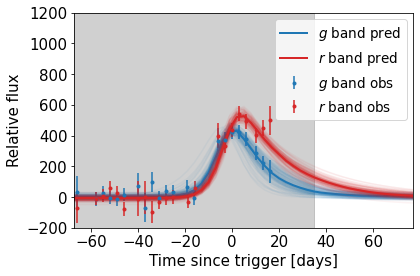

objidx: 0, timestep: 36


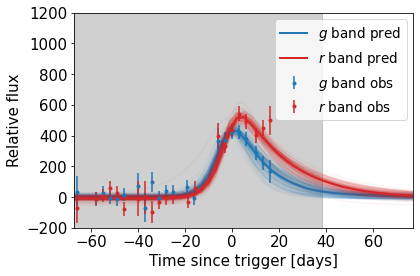

objidx: 0, timestep: 37


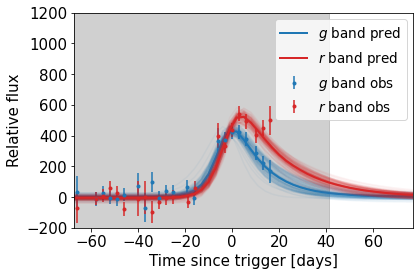

objidx: 0, timestep: 38


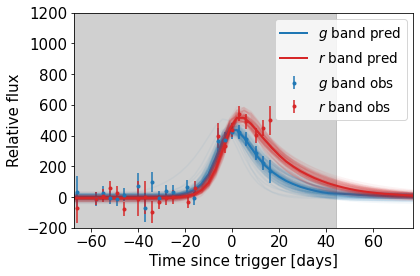

objidx: 0, timestep: 39


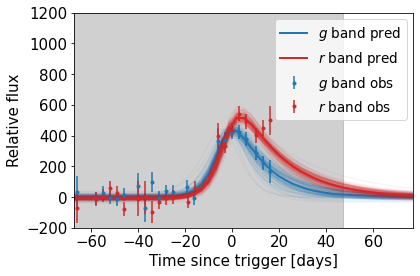

objidx: 0, timestep: 40


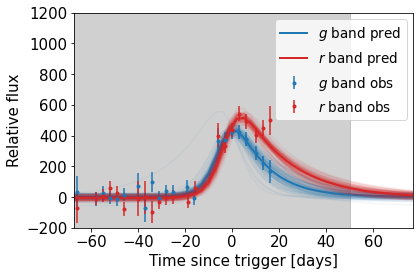

objidx: 0, timestep: 41


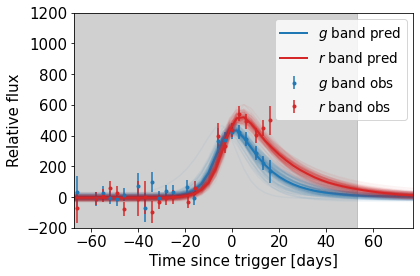

objidx: 0, timestep: 42


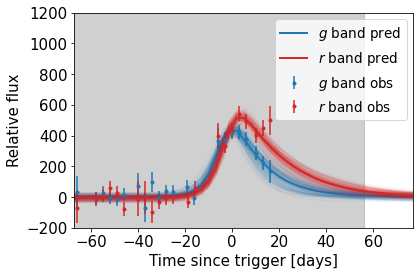

objidx: 0, timestep: 43


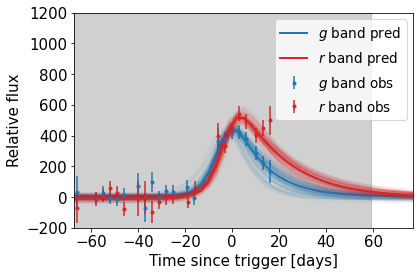

objidx: 0, timestep: 44


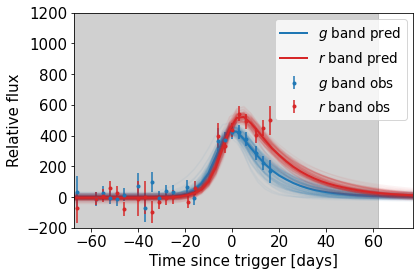

objidx: 0, timestep: 45


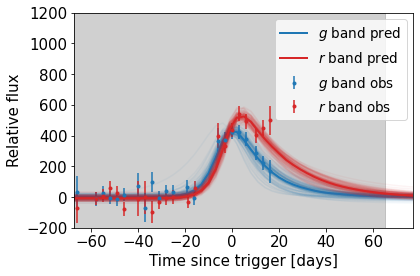

objidx: 0, timestep: 46


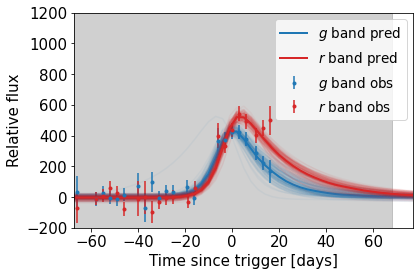

objidx: 0, timestep: 47


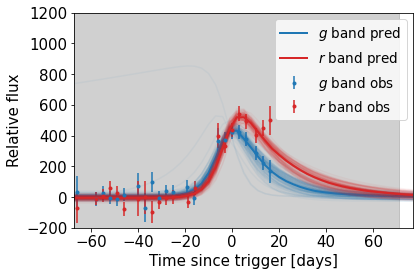

objidx: 0, timestep: 48


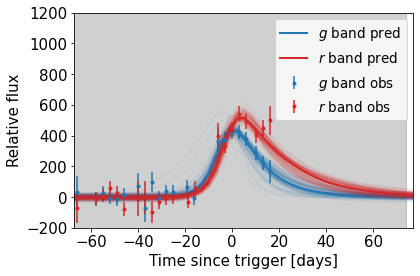

objidx: 0, timestep: 49


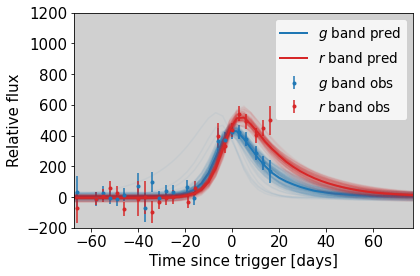

1 of 11962 1_30210882
objidx: 1, timestep: 0


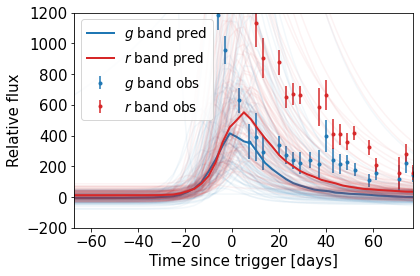

objidx: 1, timestep: 1


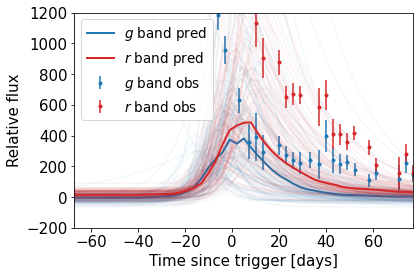

objidx: 1, timestep: 2


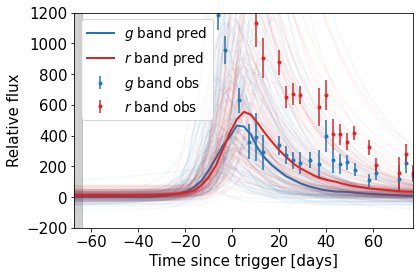

objidx: 1, timestep: 3


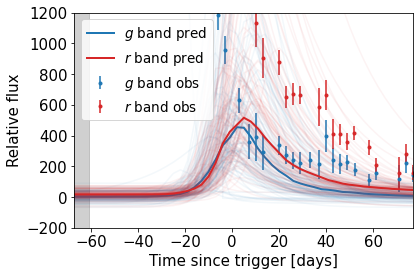

objidx: 1, timestep: 4


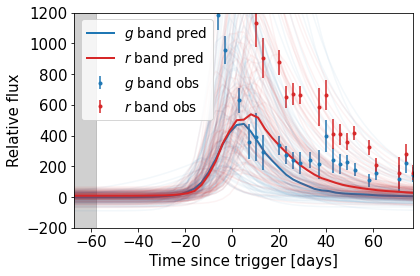

objidx: 1, timestep: 5


KeyboardInterrupt: ignored

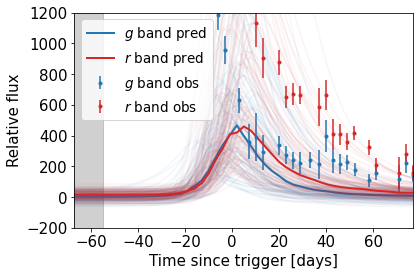

In [14]:
# Fit actual light curves with Bazin function at different time steps
import warnings
from transomaly import helpers

class_num = 1
passbands = ('g', 'r')
nobjidx = len(light_curves_sims[class_num].items())
save_flux_pred = {}
save_fluxerr_pred = {}
save_flux_interp = {}
save_fluxerr_interp = {}

for objidx, (objid, lc) in enumerate(light_curves_sims[class_num].items()):
    if objidx != 13:
        continue
    print(f"{objidx} of {nobjidx}", objid)
    save_flux_pred[objidx] = {pb: np.zeros(50) for pb in passbands}
    save_fluxerr_pred[objidx] = {pb: np.zeros(50) for pb in passbands}
    save_flux_interp[objidx] = {pb: np.zeros(50) for pb in passbands}
    save_fluxerr_interp[objidx] = {pb: np.zeros(50) for pb in passbands}

    for f, fit_until in enumerate(range(-70, 80, 3)):
        print(f"objidx: {objidx}, timestep: {f}")
        plt.close()
        try:
            time, flux, fluxerr, photflag = {}, {}, {}, {}
            t_pred1, y_pred1 = {}, {}
            respb = {}
            for pb in passbands:
                pbmask = lc['passband'] == pb
                time[pb] = lc[pbmask]['time'].data
                flux[pb] = lc[pbmask]['flux'].data
                fluxerr[pb] = lc[pbmask]['fluxErr'].data
                photflag[pb] = lc[pbmask]['photflag'].data

                # Mask out times outside of mintime and maxtime
                timemask = (time[pb] > -70) & (time[pb] < 80)
                time[pb] = time[pb][timemask]
                flux[pb] = flux[pb][timemask]
                fluxerr[pb] = fluxerr[pb][timemask]
                photflag[pb] = photflag[pb][timemask]
                if np.max(flux[pb]) < 1e-5:
                    print(objidx, objid, "Low flux due to incorrect zeropoints")
                    continue

                # Only fit up to day `fit_until`
                mask = (time[pb] <= fit_until) & (time[pb] >= -70)
                time[pb] = time[pb][mask]
                flux[pb] = flux[pb][mask]
                fluxerr[pb] = fluxerr[pb][mask]
                photflag[pb] = photflag[pb][mask]

                # Optimise fit
                autograd_numpy = False
                def objective_func(theta):
                    if autograd_numpy:
                        np1 = autograd.numpy
                    else:
                        np1 = np

                    return -log_posterior(class_num, pb, time[pb], flux[pb], fluxerr[pb], fit_until, log_sigma_intrinsic=theta[0], logA=theta[1], B=theta[2], t0=theta[3], tau_fall=theta[4], tau_rise=theta[5], np=np1)
                res = minimize(objective_func, x0[class_num][pb], method='Nelder-Mead', options={'xtol': 1e-12, 'disp': False})
                respb[pb] = res

                # print("Compute Covariance Matrix using Autograd")
                autograd_numpy = True
                hessian_ = autograd.hessian(objective_func)
                autograd_hessian_inv = lin.inv(hessian_(res.x))
                # print(autograd_hessian_inv)
                # Get Uncertaintites
                cov_matrix = autograd_hessian_inv
                sigmas = np.sqrt(np.diagonal(cov_matrix))
                # print(sigmas)

                # Ignore bad fits
                if np.any(np.isnan(cov_matrix)) or np.any(np.isnan(sigmas)) or np.any(res.x == 0.0) or np.any(sigmas==0.0) or res.x[1] <= 0 or np.any(abs(res.x)<1e-4) or np.any(np.isnan(res.x)):
                    print(f"Bad fit for objid {objidx} {objid}. Params: {res.x} sigmas {sigmas}")
                    continue
                

                # Plot draws
                t_plot, y_pred_plot = get_y_pred(80, *res.x[1:])
                t_pred1[pb] = t_plot
                y_pred1[pb] = y_pred_plot

                time_all, flux_all, fluxerr_all = lc[pbmask]['time'].data, lc[pbmask]['flux'].data, lc[pbmask]['fluxErr'].data
                spl = helpers.ErrorPropagationSpline(time_all, flux_all, fluxerr_all, k=1, N=100, ext='zeros')
                fluxinterp, fluxerrinterp = spl(t_plot)

                if time[pb].size == 0 or fit_until > time_all[-1] or fit_until >= t_plot[-1]:
                    continue
    
                # plt.figure()
                # plt.errorbar(time_all, flux_all, yerr=fluxerr_all, label='true - not used for fitting', fmt='.')
                # plt.errorbar(time[pb], flux[pb], yerr=fluxerr[pb], label='true - used for fitting', fmt='.')
                # plt.plot(t_plot, y_pred_plot, label='pred')
                # # plt.axvspan(time_all[np.argmax(time[pb])+1], max(time_all), alpha=0.2, color='grey')
                # plt.axvspan(fit_until, 80, alpha=0.2, color='grey')
                # save_y_pred_draws = []
                # for i in range(100):
                #     with warnings.catch_warnings():
                #         warnings.simplefilter("ignore")
                #         param_draws = np.random.multivariate_normal(res.x, cov_matrix)
                #     t_draw, y_pred_draw = get_y_pred(80, *param_draws[1:])
                #     save_y_pred_draws.append(y_pred_draw)
                #     # One of these Y-pred_draws has a first prediction of 10**24

                #     plt.plot(t_draw, y_pred_draw, color='black', alpha=0.1)
                # plt.plot(t_draw, np.median(save_y_pred_draws, axis=0), label='median draws')
                # plt.legend()
                # plt.xlabel('Time in days')
                # plt.ylabel(f'Flux {pb} band')
                # plt.title(f"{objidx}  {objid}")
                # plt.ylim(bottom=min(0, min(flux_all), min(y_pred_plot)), top=max(max(flux_all), max(y_pred_plot)))
                # # plt.xlim(left=max(-70, min(time_all)), right = min(80, max(time_all)))
                # plt.xlim(-70, 80)
                # plt.show()

                # # # Print best fit parameters
                # # print("\n")
                # # print(f"log(sigma)    : initial={x0[0]}, pred={res.x[0]:.2f} +- {sigmas[0]:.2f}")
                # # print(f"log(A)        : initial={x0[1]}, pred={res.x[1]:.2f} +- {sigmas[1]:.2f}")
                # # print(f"B             : initial={x0[2]}, pred={res.x[2]:.2f} +- {sigmas[2]:.2f}")
                # # print(f"t0            : initial={x0[3]}, pred={res.x[3]:.2f} +- {sigmas[3]:.2f}")
                # # print(f"tau_fall      : initial={x0[4]}, pred={res.x[4]:.2f} +- {sigmas[4]:.2f}")
                # # print(f"tau_rise      : initial={x0[5]}, pred={res.x[5]:.2f} +- {sigmas[5]:.2f}")

                # save_flux_pred[objidx][pb][f+1] = y_pred_plot[f+1]
                # save_fluxerr_pred[objidx][pb][f+1] = np.std(save_y_pred_draws, axis=0)[f+1]
                # save_flux_interp[objidx][pb][f+1] = fluxinterp[f+1]
                # save_fluxerr_interp[objidx][pb][f+1] = fluxerrinterp[f+1]


            # Figures for paper    
            fig, (ax1) = plt.subplots(nrows=1, ncols=1)
            for pb in passbands:
                pbmask = lc['passband'] == pb
                time_all, flux_all, fluxerr_all = lc[pbmask]['time'].data, lc[pbmask]['flux'].data, lc[pbmask]['fluxErr'].data
                ax1.errorbar(time_all, flux_all, yerr=fluxerr_all, label=f'${pb}$ band obs', fmt='.', color=COLPB[pb])
                # ax1.axvspan(fit_until, 80, alpha=0.2, color='grey')
                ax1.axvspan(-67, fit_until, alpha=0.2, color='grey')
                save_y_pred_draws = []
                for i in range(100):
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        param_draws = np.random.multivariate_normal(respb[pb].x, cov_matrix)
                    t_draw, y_pred_draw = get_y_pred(80, *param_draws[1:])
                    save_y_pred_draws.append(y_pred_draw)
                    ax1.plot(t_draw, y_pred_draw, color=COLPB[pb], alpha=0.05)
                ax1.plot(t_draw, np.median(save_y_pred_draws, axis=0), label=f'${pb}$ band pred', color=COLPB[pb], linewidth=2, linestyle='-')  # median
            ax1.set_ylabel("Relative flux", fontsize=15)
            ax1.set_xlabel("Time since trigger [days]", fontsize=15)
            ax1.legend(fontsize=13.5)
            # plt.ylim(bottom=min(0, min(flux_all), min(y_pred_plot)), top=max(max(flux_all), max(y_pred_plot)))
            plt.ylim(-200, 1200)  #
            plt.ylim()
            plt.xlim(-67, 77)
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=15)
            plt.tight_layout()
            plt.savefig(f"bazin_fit_example_timestep_{f}")
            plt.show()


        except EnvironmentError as e:
            print(objidx, objid, e)
            continue

    # #Compute likelihood and mask out where there is no data
    # for pb in passbands:
    #     mask = (save_fluxerr_pred[objidx][pb] != 0)
    #     yt = save_flux_interp[objidx][pb][mask]
    #     yterr = save_fluxerr_pred[objidx][pb][mask]
    #     yp = save_flux_pred[objidx][pb][mask]
    #     yperr = save_fluxerr_interp[objidx][pb][mask]

    #     negloglike = -0.5 * (yt - yp)**2 / (yterr*2 + yperr**2) - 0.5 *np.log(yterr**2 + yperr**2) - 0.5*np.log(2*np.pi)
    #     print(negloglike)
    #     fig = plt.figure()
    #     plt.errorbar(t_plot, save_flux_pred[objidx][pb], yerr=save_fluxerr_pred[objidx][pb], label='pred', fmt='.', linestyle='-')   
    #     plt.errorbar(t_plot, save_flux_interp[objidx][pb], yerr=save_fluxerr_interp[objidx][pb], label='interp data', fmt='.', linestyle='-')
    #     # plt.errorbar(time_all[time_all>=-70], flux_all[time_all>=-70], yerr=fluxerr_all[time_all>=-70], label='data', fmt='.', linestyle='-')
    #     plt.legend()
    #     plt.xlabel('Time in days')
    #     plt.ylabel(f'Flux {pb} band')
    #     plt.title(f"3 day predictions plotted plot {objidx}  {objid}")
    #     plt.ylim(bottom=min(0, min(save_flux_pred[objidx][pb]), min(save_flux_interp[objidx][pb])), top=max(max(save_flux_pred[objidx][pb]), max(save_flux_interp[objidx][pb])))
    #     # plt.xlim(left=max(-70, min(time_all)), right = min(80, max(time_all)))
    #     plt.xlim(-70, 80)
    #     plt.text(0.6, 0.7, f"$negloglike = {round(np.sum(negloglike, axis=0)/len(yt), 3)}$", horizontalalignment='left', verticalalignment='center', transform=fig.transFigure)
    #     plt.show()

    # # with open('save_real_data_from_osc_bazin_params.pickle', 'wb') as f:
    # # with open(f'save_bazin_params_class_multipb_{class_num}.pickle', 'wb') as f:
    # #     pickle.dump(save_bazin_params, f)


In [44]:
# title Similarity matrix function definitions
import json
import random
import pandas as pd
import matplotlib .pyplot as plt
import matplotlib
font = {'family': 'normal',
        'size': 12}
matplotlib.rc('font', **font)

import warnings
warnings.filterwarnings("ignore")

sntypes_map = helpers.get_sntypes()

def get_similarity_matrix(class_nums, ignore_class_names_test_on=[]):

    similarity_matrix = {}
    similarity_matrix_chi2 = {}
    for class_num in class_nums:
        class_name = sntypes_map[class_num]
        print(class_name)
        saved_scores_fp = f'bazin_similarity_scores_{class_num}_test.json'
  
        if os.path.exists(saved_scores_fp):
            print("Using saved similarity scores")
            with open(saved_scores_fp, 'r') as fp:
                similarity_score = json.load(fp)
            with open(saved_scores_fp.replace('similarity_scores_', 'similarity_scores_chi2_'), 'r') as fp:
                similarity_score_chi2 = json.load(fp)
        else:
            print("Saving similarity scores...")
            similarity_score, similarity_score_chi2 = similarity_metric(class_num, class_nums_to_test_against=class_nums)
            with open(saved_scores_fp, 'w') as fp:
                json.dump(similarity_score, fp)
            with open(saved_scores_fp.replace('similarity_scores_', 'similarity_scores_chi2_'), 'w') as fp:
                json.dump(similarity_score_chi2, fp)
        similarity_matrix[class_name] = similarity_score
        similarity_matrix_chi2[class_name] = similarity_score_chi2

    similarity_matrix = pd.DataFrame(similarity_matrix)
    similarity_matrix_chi2 = pd.DataFrame(similarity_matrix_chi2)

    similarity_matrix.to_csv('bazin_similarity_matrix.csv')
    similarity_matrix_chi2.to_csv('similarity_matrix_chi2.csv')

    print(similarity_matrix)

    similarity_matrix = similarity_matrix.drop(ignore_class_names_test_on)

    return similarity_matrix, similarity_matrix_chi2


def similarity_metric(class_num, class_nums_to_test_against):
    model_class_num = class_num
    model_class_name = sntypes_map[model_class_num]

    nobjidx = len(light_curves_sims[class_num].items())
    save_flux_pred = {}
    save_fluxerr_pred = {}
    save_flux_interp = {}
    save_fluxerr_interp = {}
    save_flux_pred_draws = {}

    class_names = [sntypes_map[class_num] for class_num in class_nums_to_test_against]
    anomaly_scores = {key: [] for key in class_names}
    anomaly_scores_chi2 = {key: [] for key in class_names}

    all_lcs_dict = {**light_curves_sims[1], **light_curves_sims[2], **light_curves_sims[3], **light_curves_sims[41], **light_curves_sims[51], **light_curves_sims[60], **light_curves_sims[64]}
    objids = list(all_lcs_dict.keys())
    random.shuffle(objids)

    ndraws = 100

    for objidx, objid in enumerate(objids[0:200]):
        lc = all_lcs_dict[objid]
        obj_class_num = int(objid.split('_')[0])
        obj_class_name = sntypes_map[obj_class_num]

        save_flux_pred[objidx] = {pb: np.zeros(50) for pb in passbands}
        save_fluxerr_pred[objidx] = {pb: np.zeros(50) for pb in passbands}
        save_flux_pred_draws[objidx] = {pb: np.zeros((50, ndraws)) for pb in passbands}
        save_flux_interp[objidx] = {pb: np.zeros(50) for pb in passbands}
        save_fluxerr_interp[objidx] = {pb: np.zeros(50) for pb in passbands}

        for f, fit_until in enumerate(range(-70, 80, 3)):
            if fit_until < -30 or fit_until > 60: 
                continue
            if f % 10 == 0: print(f"model_class_num: {class_num}, objidx: {objidx}, {objid} timestep: {f}")
            plt.close()
            time, flux, fluxerr, photflag = {}, {}, {}, {}
            t_pred1, y_pred1 = {}, {}
            respb = {}
            for pb in passbands:
                pbmask = lc['passband'] == pb
                time[pb] = lc[pbmask]['time'].data
                flux[pb] = lc[pbmask]['flux'].data
                fluxerr[pb] = lc[pbmask]['fluxErr'].data
                photflag[pb] = lc[pbmask]['photflag'].data

                # Mask out times outside of mintime and maxtime
                timemask = (time[pb] > -70) & (time[pb] < 80)
                time[pb] = time[pb][timemask]
                flux[pb] = flux[pb][timemask]
                fluxerr[pb] = fluxerr[pb][timemask]
                photflag[pb] = photflag[pb][timemask]
                if np.max(flux[pb]) < 1e-5:
                    print(objidx, objid, "Low flux due to incorrect zeropoints")
                    continue

                # Only fit up to day `fit_until`
                mask = (time[pb] <= fit_until) & (time[pb] >= -70)
                time[pb] = time[pb][mask]
                flux[pb] = flux[pb][mask]
                fluxerr[pb] = fluxerr[pb][mask]
                photflag[pb] = photflag[pb][mask]

                # Optimise fit
                autograd_numpy = False
                def objective_func(theta):
                    if autograd_numpy:
                        np1 = autograd.numpy
                    else:
                        np1 = np

                    return -log_posterior(model_class_num, pb, time[pb], flux[pb], fluxerr[pb], fit_until, log_sigma_intrinsic=theta[0], logA=theta[1], B=theta[2], t0=theta[3], tau_fall=theta[4], tau_rise=theta[5], np=np1)
                res = minimize(objective_func, x0[model_class_num][pb], method='Nelder-Mead', options={'xtol': 1e-12, 'disp': False})
                respb[pb] = res

                # print("Compute Covariance Matrix using Autograd")
                autograd_numpy = True
                hessian_ = autograd.hessian(objective_func)
                autograd_hessian_inv = lin.inv(hessian_(res.x))
                # print(autograd_hessian_inv)
                # Get Uncertaintites
                cov_matrix = autograd_hessian_inv
                sigmas = np.sqrt(np.diagonal(cov_matrix))
                # print(sigmas)

                # Ignore bad fits
                if np.any(np.isnan(cov_matrix)) or np.any(np.isnan(sigmas)) or np.any(res.x == 0.0) or np.any(sigmas==0.0) or res.x[1] <= 0 or np.any(abs(res.x)<1e-4) or np.any(np.isnan(res.x)):
                    print(f"Bad fit for objid {objidx} {objid}. Params: {res.x} sigmas {sigmas}")
                    continue

                # Get draws
                t_plot, y_pred_plot = get_y_pred(80, *res.x[1:])
                t_pred1[pb] = t_plot
                y_pred1[pb] = y_pred_plot
                save_y_pred_draws = []
                for i in range(ndraws):
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        param_draws = np.random.multivariate_normal(respb[pb].x, cov_matrix)
                    t_draw, y_pred_draw = get_y_pred(80, *param_draws[1:])
                    save_y_pred_draws.append(y_pred_draw)

                time_all, flux_all, fluxerr_all = lc[pbmask]['time'].data, lc[pbmask]['flux'].data, lc[pbmask]['fluxErr'].data
                spl = helpers.ErrorPropagationSpline(time_all, flux_all, fluxerr_all, k=1, N=100, ext='zeros')
                fluxinterp, fluxerrinterp = spl(t_plot)

                if time[pb].size == 0 or fit_until > time_all[-1] or fit_until >= t_plot[-1]:
                    continue

                save_flux_pred[objidx][pb][f+1] = y_pred_plot[f+1]
                save_fluxerr_pred[objidx][pb][f+1] = np.std(save_y_pred_draws, axis=0)[f+1]
                save_flux_pred_draws[objidx][pb][f+1] = np.array(save_y_pred_draws)[:,f+1]
                save_flux_interp[objidx][pb][f+1] = fluxinterp[f+1]
                save_fluxerr_interp[objidx][pb][f+1] = fluxerrinterp[f+1]

            # # Plot fits at different time steps
            # fig, (ax1) = plt.subplots(nrows=1, ncols=1)
            # for pb in passbands:
            #     pbmask = lc['passband'] == pb
            #     time_all, flux_all, fluxerr_all = lc[pbmask]['time'].data, lc[pbmask]['flux'].data, lc[pbmask]['fluxErr'].data
            #     ax1.errorbar(time_all, flux_all, yerr=fluxerr_all, label=f'${pb}$ band obs', fmt='.', color=COLPB[pb])
            #     # ax1.axvspan(fit_until, 80, alpha=0.2, color='grey')
            #     ax1.axvspan(-67, fit_until, alpha=0.2, color='grey')
            #     save_y_pred_draws = []
            #     for i in range(100):
            #         with warnings.catch_warnings():
            #             warnings.simplefilter("ignore")
            #             param_draws = np.random.multivariate_normal(respb[pb].x, cov_matrix)
            #         t_draw, y_pred_draw = get_y_pred(80, *param_draws[1:])
            #         save_y_pred_draws.append(y_pred_draw)
            #         ax1.plot(t_draw, y_pred_draw, color=COLPB[pb], alpha=0.05)
            #     ax1.plot(t_draw, np.median(save_y_pred_draws, axis=0), label=f'${pb}$ band pred', color=COLPB[pb], linewidth=2, linestyle='-')  # median
            # ax1.set_ylabel("Relative flux", fontsize=15)
            # ax1.set_xlabel("Time since trigger [days]", fontsize=15)
            # ax1.legend(fontsize=13.5)
            # plt.ylim(bottom=min(0, min(flux_all), min(y_pred_plot)), top=max(max(flux_all), max(y_pred_plot)))
            # plt.xlim(-67, 77)
            # plt.xticks(fontsize=15)
            # plt.yticks(fontsize=15)
            # plt.tight_layout()
            # plt.show()
            # plt.close()
        
        # Get anomaly scores
        npb = 0
        chi2 = 0
        like = 0
        negloglike = 0
        maskzeros = True
        for pb in passbands:
            yt = save_flux_interp[objidx][pb]
            yterr = save_fluxerr_pred[objidx][pb]
            yp = save_flux_pred[objidx][pb]
            yperr = save_fluxerr_interp[objidx][pb]
            maskzeros = ((yterr != 0) * (np.isfinite(yterr))) & maskzeros
            try:
                chi2 += ((yp - yt)/yterr)**2
                like += np.exp(-0.5*(yp-yt)**2 / (yterr**2+yperr**2)) * (2*np.pi*(yterr**2+yperr**2))**-0.5
                negloglike += -(-0.5 * (yp - yt)**2 / (yterr*2 + yperr**2))# - 0.5 *np.log(yterr**2 + yperr**2) - 0.5*np.log(2*np.pi))
                npb += 1
            except ValueError as e:
                print(f"Failed chi2 object {objids_test[sidx + s]}", e)
            # import pdb; pdb.set_trace()
        if not np.any(maskzeros):
            print("here not any maskzeros")
            continue

        chi2 = chi2[maskzeros] / npb
        like = like[maskzeros] / npb
        negloglike = negloglike[maskzeros] / npb
        
        anomaly_scores_lc = np.array(negloglike)
        anomaly_score_max = max(anomaly_scores_lc)
        anomaly_scores[obj_class_name].append(anomaly_score_max)

        anomaly_scores_lc_chi2 = np.array(chi2)
        anomaly_score_chi2_max = max(anomaly_scores_lc_chi2)
        anomaly_scores_chi2[obj_class_name].append(anomaly_score_chi2_max)

        # Example transients for paper
        fig, (ax1) = plt.subplots(nrows=1, ncols=1)
        for pb in passbands:
            pbmask = lc['passband'] == pb
            time_all, flux_all, fluxerr_all = lc[pbmask]['time'].data, lc[pbmask]['flux'].data, lc[pbmask]['fluxErr'].data
            # ax1.errorbar(t_plot, save_flux_pred[objidx][pb], yerr=save_fluxerr_pred[objidx][pb], label=f'${pb}$ band pred', fmt='.', linestyle='-', color='pink')   
            # ax1.errorbar(t_plot, save_flux_interp[objidx][pb], yerr=save_fluxerr_interp[objidx][pb], label=f'${pb}$ band interp data', fmt='.', linestyle='-', color='cyan')
            ax1.errorbar(time_all, flux_all, yerr=fluxerr_all, label=f'${pb}$ band obs', fmt='.', color=COLPB[pb])
            # plt.errorbar(time_all[time_all>=-70], flux_all[time_all>=-70], yerr=fluxerr_all[time_all>=-70], label='data', fmt='.', linestyle='-')
            for drawidx in range(ndraws):
                ax1.plot(t_plot, save_flux_pred_draws[objidx][pb][:,drawidx], color=COLPB[pb], alpha=0.05)
            ax1.plot(t_plot, np.median(save_flux_pred_draws[objidx][pb], axis=1), label=f'${pb}$ band pred median', color=COLPB[pb], linewidth=2, linestyle='-')  # median
        ax1.set_ylabel("Relative flux", fontsize=15)
        ax1.set_xlabel("Time since trigger [days]", fontsize=15)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        ax1.legend(fontsize=13.5)
        # plt.title(f"3 day predictions plotted plot {objidx}  {objid}")
        plt.ylim(bottom=min(0, min(save_flux_pred[objidx][pb]), min(save_flux_interp[objidx][pb])), top=max(max(save_flux_pred[objidx][pb]), max(save_flux_interp[objidx][pb])))
        # plt.xlim(left=max(-70, min(time_all)), right = min(80, max(time_all)))
        plt.xlim(-67, 77)
        # plt.ylim(-200, 1200)  #
        plt.text(0.6, 0.7, f"$negloglike = {round(max(negloglike), 3)}$", horizontalalignment='left', verticalalignment='center', transform=fig.transFigure)
        plt.text(0.6, 0.6, f"$chi2 = {round(max(chi2), 3)}$", horizontalalignment='left', verticalalignment='center', transform=fig.transFigure)
        plt.tight_layout()
        # plt.savefig(f"bazin_3 day predictions_{objid}")
        plt.show()
        plt.close()

    similarity_score = {key: [] for key in class_names}
    similarity_score_chi2 = {key: [] for key in class_names}
    for c in class_names:
        similarity_score[c] = np.median(anomaly_scores[c])
        similarity_score_chi2[c] = np.median(anomaly_scores_chi2[c])

    return similarity_score, similarity_score_chi2


def plot_similarity_matrix(similarity_matrix):
    font = {'family': 'normal',
            'size': 36}
    matplotlib.rc('font', **font)

    xrange, yrange = similarity_matrix.shape
    similarity_matrix = similarity_matrix.T
    # similarity_matrix = similarity_matrix[
    #     ['SNIa', 'SNIa-x', 'SNII', 'SNIbc', 'SLSN-I', 'TDE', 'AGN', 'SNIIn', 'Ia-91bg', 'CART', 'TDE', 'PISN',
    #      'Kilonova']]
    xlabels = similarity_matrix.columns.values
    ylabels = similarity_matrix.index.values


    maxval = min(50, similarity_matrix.values.max())
    plt.figure(figsize=(15,12))
    plt.imshow(similarity_matrix, cmap=plt.cm.RdBu_r, vmin=6, vmax=maxval)#, norm=colors.LogNorm())

    cb = plt.colorbar()
    # cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=27)
    plt.xticks(np.arange(xrange), xlabels, rotation=90, fontsize=27)
    plt.yticks(np.arange(yrange), ylabels, fontsize=27)

    thresh_q3 = 0.75 * maxval
    thresh_q1 = 0.25 * maxval
    for i in range(xrange):
        for j in range(yrange):
            c = similarity_matrix.iloc[j, i]
            if c > 100:
                cell_text = f"{c:.0f}"
            elif c > 10:
                cell_text = f"{c:.1f}"
            else:
                cell_text = f"{c:.2f}"
            plt.text(i, j, cell_text, va='center', ha='center',
                     color="white" if c < thresh_q1 or c > thresh_q3 else "black", fontsize=14)

    plt.ylabel('Trained on')
    plt.xlabel('Tested on')
    plt.tight_layout()
    print("Saving matrix plot...")
    plt.savefig("bazin_similarity_matrix_yterr_and_yperr.pdf")

SNIa-norm
Saving similarity scores...
model_class_num: 1, objidx: 0, 3_82984210 timestep: 20
model_class_num: 1, objidx: 0, 3_82984210 timestep: 30
model_class_num: 1, objidx: 0, 3_82984210 timestep: 40


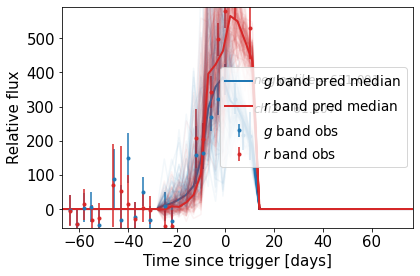

model_class_num: 1, objidx: 1, 51_77274075 timestep: 20
model_class_num: 1, objidx: 1, 51_77274075 timestep: 30


In [ ]:
# title # Plot similarity matrix
import warnings
passbands = ('g', 'r')

class_nums = [1, 2, 3, 41, 51, 60, 64]

similarity_matrix, similarity_matrix_chi2 = get_similarity_matrix(class_nums, ignore_class_names_test_on=[])
plot_similarity_matrix(similarity_matrix)

In [ ]:
# -0.5 * (yt - yp)**2 / (yterr*2 + yperr**2) - 0.5 *np.log(yterr**2 + yperr**2) - 0.5*np.log(2*np.pi)
# print(yt, yp, yterr, yperr)
import transomaly
from transomaly import helpers

In [ ]:
model = build_model(X_train, passbands=('g',), reframe=False, probabilistic=True, nunits=50, bayesian=False, dropout_rate=0.2)

# Load and set weights
with open('save_weights_bazin_mle.pickle', 'rb') as fp:
    load_weights = pickle.load(fp)

model.set_weights(load_weights)

model.compile(loss=negloglike(), optimizer=tf.optimizers.Adam(learning_rate=0.01))
# tcn_full_summary(model, expand_residual_blocks=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=0, batch_size=64, verbose=2)
model.evaluate(X_train, y_train)
# plot_history(history, 'bazinloss')

In [ ]:
yhat = model(X_train)
y_pred = np.asarray(yhat.mean())
y_pred_std = np.asarray(yhat.stddev())
print(y_pred_std.shape)
pidx = 99
time = t[pidx, 1:]
plt.figure()
plt.errorbar(time, y_train[pidx], yerr=sigma, fmt='.', label='true data')
plt.errorbar(time, y_pred[pidx], yerr=y_pred_std[pidx], fmt='x', c='tab:orange', label='one draw from posterior')
plt.legend()


plt.figure()
plt.scatter(time, y_pred_std[pidx], label='predicted sigma one draw')
plt.hlines(y=sigma, xmin=min(time), xmax=max(time), label='true sigma')
# plt.plot(time, sigma, color='k', label='true sigma')
plt.legend()


sampled_ypred = []
sampled_ystd = []
draws = []
ns = 100
for i in range(ns):
    sampled_yhat = model(X_train)
    sampled_ypred.append(np.asarray(sampled_yhat.mean()))
    sampled_ystd.append(np.asarray(sampled_yhat.stddev()))
    draws.append(np.random.normal(sampled_yhat.mean(), sampled_yhat.stddev()))
mean_sampled_ypred = np.mean(np.array(draws), axis=0)
std_sampled_ypred = np.std(np.array(draws), axis=0)
plt.figure()
plt.errorbar(time, y_train[pidx], yerr=sigma, fmt='.', label='true data')
# for sp in range(ns):
#     plt.errorbar(time, sampled_ypred[sp][pidx], yerr=sampled_ystd[sp][pidx], fmt='.', c='black', alpha=0.01)
plt.errorbar(time, mean_sampled_ypred[pidx], yerr=std_sampled_ypred[pidx], fmt='x', c='tab:orange', alpha=1, label=f'mean of {ns} draws')
plt.legend()


plt.figure()
plt.scatter(time, std_sampled_ypred[pidx], label=f'predicted sigma of {ns} draws')
plt.hlines(y=sigma, xmin=min(time), xmax=max(time), label='true sigma')
# plt.plot(time, sigma[pidx], color='k', label='true sigma')
plt.legend()


In [ ]:
# # Save model weights
# import pickle
# weights = model.get_weights()
# with open('save_weights_bazin_mle.pickle', 'wb') as fp:
#     pickle.dump(weights, fp)

# # Load and set weights
# with open('save_weights_bazin_mle.pickle', 'rb') as fp:
#     load_weights = pickle.load(fp)

# model.set_weights(load_weights)

In [ ]:
print(weights)

In [ ]:
# Build model.
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglike())
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
print(model.weights)
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

In [ ]:
    for npred in range(1, 2):
        SCRIPT_DIR = 'transomaly/'  # os.path.dirname(os.path.abspath(__file__))
        data_dir = os.path.join(SCRIPT_DIR, '..', 'data/ZTF_20190512')
        save_dir = os.path.join(SCRIPT_DIR, '..', 'data/saved_light_curves')
        training_set_dir = os.path.join(SCRIPT_DIR, '..', 'data/training_set_files')
        get_data_func = astrorapid.get_training_data.get_data_from_snana_fits
        fig_dir = os.path.join(SCRIPT_DIR, '..', 'plots')
        passbands = ('g', 'r')
        contextual_info = ()
        known_redshift = True if 'redshift' in contextual_info else False
        nprocesses = None
        class_nums = (1,)
        otherchange = 'single_object_1_50075859'
        nsamples = 1000
        extrapolate_gp = True
        redo = False
        train_epochs = 10000
        retrain = False
        reframe_problem = False
        # npred = 1
        probabilistic = True
        batch_size = 128
        nunits = 30
        train_from_last_stop = 0
        normalise = True
        use_uncertainties = True
        bayesian = True

        # nn_architecture_change = 'norm_onepointpred{}timestepsinfuture_steps{}normalised_{}negloglike_predict_last{}_timesteps_nodropout_100lstmneurons'.format(npred,'probabilistic_' if probabilistic else '', 'reframe_Xy_' if reframe_problem else '', npred)  # 'normalise_mse_withmasking_1000lstmneurons'  # 'chi2'  # 'mse'
        nn_architecture_change = f"NotDenseFlipoutOnly1TCN_{'probabilistic_' if probabilistic else ''}bayesian{bayesian}_uncertainties{use_uncertainties}_predictfuture{npred}point_normalised{normalise}_nodropout_{nunits}units_batchsize{batch_size}"

        fig_dir = os.path.join(fig_dir, "model_{}_ci{}_ns{}_c{}".format(otherchange, contextual_info, nsamples, class_nums))
        if not os.path.exists(fig_dir):
            os.makedirs(fig_dir)

        preparearrays = PrepareTrainingSetArrays(passbands, contextual_info, data_dir, save_dir, training_set_dir, redo, get_data_func)
        X_train, X_test, y_train, y_test, Xerr_train, Xerr_test, yerr_train, yerr_test, \
        timesX_train, timesX_test, labels_train, labels_test, objids_train, objids_test = \
            preparearrays.make_training_set(class_nums, nsamples, otherchange, nprocesses, extrapolate_gp, reframe=reframe_problem, npred=npred, normalise=normalise, use_uncertainties=use_uncertainties)

        model, model_name = train_model(X_train, X_test, y_train, y_test, yerr_train, yerr_test, fig_dir=fig_dir, epochs=train_epochs,
                            retrain=retrain, passbands=passbands, model_change=nn_architecture_change, reframe=reframe_problem, probabilistic=probabilistic, train_from_last_stop=train_from_last_stop, batch_size=batch_size, nunits=nunits, use_uncertainties=use_uncertainties, bayesian=bayesian)

        plot_metrics(model, model_name, X_test, y_test, timesX_test, yerr_test, labels_test, objids_test, passbands=passbands,
                     fig_dir=fig_dir, nsamples=nsamples, data_dir=data_dir, save_dir=save_dir, nprocesses=nprocesses, plot_gp=True, extrapolate_gp=extrapolate_gp, reframe=reframe_problem, plot_name='', npred=npred, probabilistic=probabilistic, known_redshift=known_redshift, get_data_func=get_data_func, normalise=normalise, bayesian=bayesian)
        
        plot_metrics(model, model_name, X_train, y_train, timesX_train, yerr_train, labels_train, objids_train, passbands=passbands,
                    fig_dir=fig_dir, nsamples=nsamples, data_dir=data_dir, save_dir=save_dir, nprocesses=nprocesses, plot_gp=True, extrapolate_gp=extrapolate_gp, reframe=reframe_problem, plot_name='_training_set', npred=npred, probabilistic=probabilistic, known_redshift=known_redshift, get_data_func=get_data_func, normalise=normalise, bayesian=bayesian)

        # # Test on other classes  #51,60,62,70 AndOtherTypes
        # X_train, X_test, y_train, y_test, Xerr_train, Xerr_test, yerr_train, yerr_test, \
        # timesX_train, timesX_test, labels_train, labels_test, objids_train, objids_test = \
        #     preparearrays.make_training_set(class_nums=(1,51,), nsamples=1, otherchange='getKnAndOtherTypes', nprocesses=nprocesses, extrapolate_gp=extrapolate_gp, reframe=reframe_problem, npred=npred, normalise=normalise, use_uncertainties=use_uncertainties)
        # plot_metrics(model, model_name, X_train, y_train, timesX_train, yerr_train, labels_train, objids_train, passbands=passbands,
        #             fig_dir=fig_dir, nsamples=nsamples, data_dir=data_dir, save_dir=save_dir, nprocesses=nprocesses, plot_gp=True, extrapolate_gp=extrapolate_gp, reframe=reframe_problem, plot_name='anomaly', npred=npred, probabilistic=probabilistic, known_redshift=known_redshift, get_data_func=get_data_func, normalise=normalise, bayesian=bayesian)


In [ ]:
X_train.shape

In [ ]:
# loss=lambda y, rv_y: -rv_y.log_prob(y)
# model.set_weights(old_weights)
model.compile(loss=negloglike_with_error(), optimizer='adam')
model.evaluate(X_test, y_test)
# Default model

In [ ]:
old_weights = model.get_weights()
with open('save_weights_400epochs_nonbayesian.pickle', 'rb') as fp:
    load_weights = pickle.load(fp)

In [ ]:
print(old_weights[0])
print(load_weights[0])

In [ ]:
yhat = model(X_test)
y_pred = np.asarray(yhat.mean())
y_pred_std = np.asarray(yhat.stddev())
ns = 10
sampled_ypred = []
sampled_ystd = []
for i in range(ns):
    sampled_yhat = model(X_test)
    sampled_ypred.append(np.asarray(sampled_yhat.mean()))
    sampled_ystd.append(np.asarray(sampled_yhat.stddev()))


In [ ]:
np.std(np.array(sampled_ypred), axis=0).shape

In [ ]:
old_weights = model.get_weights()
with open('save_weights_400epochs_nonbayesian.pickle', 'rb') as fp:
    load_weights = pickle.load(fp)

initialise_weights = copy.deepcopy(old_weights)
initialise_weights[0] = load_weights[0]
initialise_weights[2] = load_weights[1]
initialise_weights[3] = load_weights[2]
initialise_weights[5] = load_weights[3]
initialise_weights[6] = load_weights[4]
initialise_weights[8] = load_weights[5]
initialise_weights[9] = load_weights[6]
initialise_weights[11] = load_weights[7]
initialise_weights[12] = load_weights[8]
initialise_weights[14] = load_weights[9]
initialise_weights[15] = load_weights[10]
initialise_weights[17] = load_weights[11]
initialise_weights[18] = load_weights[12]
initialise_weights[20] = load_weights[13]
initialise_weights[21] = load_weights[14]
initialise_weights[23] = load_weights[15]
initialise_weights[24] = load_weights[16]
initialise_weights[26] = load_weights[17]
initialise_weights[27] = load_weights[18]
initialise_weights[28] = load_weights[19]

model.set_weights(old_weights)

In [ ]:
new_weights = model.get_weights()
yhat = model(X_test)
y_pred = np.asarray(yhat.mean())
y_pred_std = np.asarray(yhat.stddev())
np.mean(np.square(y_pred - y_test[:,:,:2]))
#0.09301782987233782


In [ ]:
for i, w in enumerate(load_weights):
    print(i, w.shape)

In [ ]:
for i, w in enumerate(old_weights):
    print(i, w.shape, w)

In [ ]:
plot_metrics(model, model_name, X_train, y_train, timesX_train, yerr_train, labels_train, objids_train, passbands=passbands,
            fig_dir=fig_dir, nsamples=nsamples, data_dir=data_dir, save_dir=save_dir, nprocesses=nprocesses, plot_gp=True, extrapolate_gp=extrapolate_gp, reframe=reframe_problem, plot_name='_training_set', npred=npred, probabilistic=probabilistic, known_redshift=known_redshift, get_data_func=get_data_func, normalise=normalise, bayesian=bayesian)


In [ ]:
from tensorflow.keras import initializers
initializers.RandomNormal(stddev=0.01)
print(weights)

In [ ]:
# weights_400epochs_nonbayesian = np.array(model.get_weights())
# import pickle
# with open('save_weights_400epochs_nonbayesian.pickle', 'wb') as fp:
#     pickle.dump(weights_400epochs_nonbayesian, fp)

In [ ]:
# weights_400epochs_bayesian = np.array(model.get_weights())
# import pickle
# with open('save_weights_400epochs_bayesian.pickle', 'wb') as fp:
#     pickle.dump(weights_400epochs_bayesian, fp)

In [ ]:

weights = np.array(model.get_weights())
for w in weights:
    print(w.shape)

In [ ]:
for lay in model.layers:
    print(lay.name)
    w = lay.get_weights()
    print(len(w))
    for i in range(len(w)):
      print(w[i].shape)

In [ ]:

tcn_full_summary(model, expand_residual_blocks=True)


In [ ]:
# ! git config --user.email "daniel.muthukrishna@gmail.com"
# ! git config --user.name "daniel-muthukrishna"
# ! git stash
# ! git pull

In [ ]:
# # not-Bayesian:
# Model: "sequential_1"
# _________________________________________________________________
# Layer (type)                 Output Shape              Param #   
# =================================================================
# masking_1 (Masking)          (None, 49, 2)             0         
# _________________________________________________________________
# matching_conv1D (Conv1D)     (None, 49, 30)            90        
# _________________________________________________________________
# activation_14 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_0 (Conv1D)            (None, 49, 30)            150       
# _________________________________________________________________
# activation_12 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_8 (Spatial (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_1 (Conv1D)            (None, 49, 30)            1830      
# _________________________________________________________________
# activation_13 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_9 (Spatial (None, 49, 30)            0         
# _________________________________________________________________
# matching_identity (Lambda)   (None, 49, 30)            0         
# _________________________________________________________________
# activation_17 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_0 (Conv1D)            (None, 49, 30)            1830      
# _________________________________________________________________
# activation_15 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_10 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_1 (Conv1D)            (None, 49, 30)            1830      
# _________________________________________________________________
# activation_16 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_11 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# matching_identity (Lambda)   (None, 49, 30)            0         
# _________________________________________________________________
# activation_20 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_0 (Conv1D)            (None, 49, 30)            1830      
# _________________________________________________________________
# activation_18 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_12 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_1 (Conv1D)            (None, 49, 30)            1830      
# _________________________________________________________________
# activation_19 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_13 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# matching_identity (Lambda)   (None, 49, 30)            0         
# _________________________________________________________________
# activation_23 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_0 (Conv1D)            (None, 49, 30)            1830      
# _________________________________________________________________
# activation_21 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_14 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_1 (Conv1D)            (None, 49, 30)            1830      
# _________________________________________________________________
# activation_22 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_15 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# lambda_1 (Lambda)            multiple                  0         
# _________________________________________________________________
# time_distributed_1 (TimeDist (None, 49, 4)             124       
# _________________________________________________________________
# distribution_lambda_1 (Distr ((None, 49, 2), (None, 49 0         
# =================================================================
# Total params: 13,174
# Trainable params: 13,174
# Non-trainable params: 0

# # Bayesian network:
# _________________________________________________________________
# Layer (type)                 Output Shape              Param #   
# =================================================================
# masking_3 (Masking)          (None, 49, 2)             0         
# _________________________________________________________________
# matching_conv1D (Conv1DFlipo (None, 49, 30)            150       
# _________________________________________________________________
# activation_14 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_0 (Conv1DFlipout)     (None, 49, 30)            270       
# _________________________________________________________________
# activation_12 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_8 (Spatial (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_1 (Conv1DFlipout)     (None, 49, 30)            3630      
# _________________________________________________________________
# activation_13 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_9 (Spatial (None, 49, 30)            0         
# _________________________________________________________________
# matching_identity (Lambda)   (None, 49, 30)            0         
# _________________________________________________________________
# activation_17 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_0 (Conv1DFlipout)     (None, 49, 30)            3630      
# _________________________________________________________________
# activation_15 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_10 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_1 (Conv1DFlipout)     (None, 49, 30)            3630      
# _________________________________________________________________
# activation_16 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_11 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# matching_identity (Lambda)   (None, 49, 30)            0         
# _________________________________________________________________
# activation_20 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_0 (Conv1DFlipout)     (None, 49, 30)            3630      
# _________________________________________________________________
# activation_18 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_12 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_1 (Conv1DFlipout)     (None, 49, 30)            3630      
# _________________________________________________________________
# activation_19 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_13 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# matching_identity (Lambda)   (None, 49, 30)            0         
# _________________________________________________________________
# activation_23 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_0 (Conv1DFlipout)     (None, 49, 30)            3630      
# _________________________________________________________________
# activation_21 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_14 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_1 (Conv1DFlipout)     (None, 49, 30)            3630      
# _________________________________________________________________
# activation_22 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_15 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# lambda_1 (Lambda)            multiple                  0         
# _________________________________________________________________
# time_distributed_3 (TimeDist (None, 49, 4)             244       
# _________________________________________________________________
# distribution_lambda_3 (Distr ((None, 49, 2), (None, 49 0         
# =================================================================
# Total params: 26,074
# Trainable params: 26,074
# Non-trainable params: 0

In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

In [ ]:
# Deleted code
    # # sigma_intrinsic prior
    # sigma_intrinsic_mean = 25
    # sigma_intrinsic_sigma = 13
    # sigma_log_prior = -0.5*np.log(2*np.pi*sigma_intrinsic_sigma**2)-0.5*(sigma_intrinsic-sigma_intrinsic_mean)**2/sigma_intrinsic_sigma**2

    # # A prior
    # A_mean = 891
    # A_sigma = 536
    # A_log_prior = -0.5*np.log(2*np.pi*A_sigma**2)-0.5*(A-A_mean)**2/A_sigma**2

    # # B prior
    # B_mean = -26
    # B_sigma = 260
    # B_log_prior = -0.5*np.log(2*np.pi*B_sigma**2)-0.5*(B-B_mean)**2/B_sigma**2

    # # t0 prior
    # t0_mean = -3.5
    # t0_sigma = 6.4
    # t0_log_prior = -0.5*np.log(2*np.pi*t0_sigma**2)-0.5*(t0-t0_mean)**2/t0_sigma**2

    # # tau_fall prior
    # tau_fall_mean = 16.2
    # tau_fall_sigma = 10.8
    # tau_fall_log_prior = -0.5*np.log(2*np.pi*tau_fall_sigma**2)-0.5*(tau_fall-tau_fall_mean)**2/tau_fall_sigma**2

    # # tau_rise prior
    # tau_rise_mean = -3.4
    # tau_rise_sigma = 1.3
    # tau_rise_log_prior = -0.5*np.log(2*np.pi*tau_rise_sigma**2)-0.5*(tau_rise-tau_rise_mean)**2/tau_rise_sigma**2

    # log_prior = np.log(1) + sigma_log_prior + A_log_prior + B_log_prior + tau_fall_log_prior + tau_rise_log_prior